# GAN-to generate data for BTC



In [19]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import random
import sys
import tensorflow as tf
import pandas as pd

from keras import backend as K
from keras.layers import Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.merge import concatenate
from keras.models import Sequential, Model
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils import to_categorical

In [20]:
def save_data(data, file_name=None):
    file_name = file_name if file_name is not None else 'gen_data'
    #path = 'gan/gen-data/'
    #file_name = path + file_name
    
    np.save(file_name, data)
    print("Data successfully saved to {}".format(file_name))
    
def load_data(file_name):
    #path = 'gan/gen-data/'
    file_name = file_name + '.npy'
    
    gen_data = np.load(file_name, allow_pickle=True)
    return gen_data

## Numerical Data

### Generating Numerical Data

In [22]:
x_train

array([[ 1.45801204,  6.09506574],
       [-0.46655784,  5.80114231],
       [ 0.4887693 ,  5.71306665],
       ...,
       [-0.85748491,  6.41407976],
       [ 1.71603195,  5.89972094],
       [ 2.61741192,  8.90431553]])

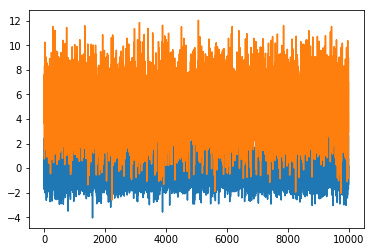

In [23]:
plt.plot(x_train)

### GAN for Numerical Data

In [24]:
class GANNumerical():
    
    def __init__(self):
        self.data_shape = (5,)
        self.noise_shape = (10,)

        # Manually tune down learning rate to avoid oscillation
        optimizer = Adam()#lr=0.0002, beta_1=0.5

        # -------------
        # Discriminator
        # -------------
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mean_squared_error',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        # ---------
        # Generator
        # ---------
        self.generator = self.build_generator()
        self.generator.compile(loss='mean_squared_error',
                               optimizer=optimizer)
        # --------
        # Combined
        # --------
        # The combined model is created by stacking generator and discriminator.
        # Noise ---Generator--> Generated Data ---Discriminator--> Validity
        
        z = Input(shape=self.noise_shape)
        data = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        
        validity = self.discriminator(data)

        self.combined = Model(z, validity)
        self.combined.compile(loss='mean_squared_error',
                              optimizer=optimizer)

        
    def save_model(self, version=None):
        if version is None:
            self.discriminator.save('gan/models/toy-numerical-discriminatorAV.h5')
            self.generator.save('gan/models/toy-numerical-generatorAV.h5')
            self.combined.save('gan/models/toy-numerical-combinedAV.h5')
        else:
            self.discriminator.save('gan/models/toy-numerical-discriminatorAV-{}.h5'.format(version))
            self.generator.save('gan/models/toy-numerical-generatorAV-{}.h5'.format(version))
            self.combined.save('gan/models/toy-numerical-combinedAV-{}.h5'.format(version))
        
        
    def load_model(self, version=None): 
        if version is None:
            self.discriminator = load_model('gan/models/toy-numerical-discriminatorAV.h5')
            self.generator = load_model('gan/models/toy-numerical-generatorAV.h5')
            self.combined = load_model('gan/models/toy-numerical-combinedAV.h5')
        else:
            self.discriminator = load_model('gan/models/toy-numerical-discriminatorAV-{}.h5'.format(version))
            self.generator = load_model('gan/models/toy-numerical-generatorAV-{}.h5'.format(version))
            self.combined = load_model('gan/models/toy-numerical-combinedAV-{}.h5'.format(version))
            
        
    def build_discriminator(self):
        model = Sequential()
        model.add(Dense(8, input_shape=self.data_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(16))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()

        # Discriminator takes an image as an input and outputs its validity
        data = Input(shape=self.data_shape)
        validity = model(data)

        return Model(data, validity)

        
    def build_generator(self):
        # BatchNormalization maintains the mean activation close to 0
        # and the activation standard deviation close to 1
        model = Sequential()
        model.add(Dense(16, input_shape=self.noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(32))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(5))
        
        model.summary()

        # Generator takes noise as an input and outputs an image
        noise = Input(shape=self.noise_shape)
        data = model(noise)

        return Model(noise, data)
    
    
    def train(self, x_train, epochs=50000, batch_size=128, save_model_interval=5000):

        half_batch = int(batch_size / 2)
        
        for epoch in range(epochs):
            # -------------------
            # Train Discriminator
            # -------------------
            # Select a random half batch of images
            idx = np.random.randint(0, x_train.shape[0], half_batch)
            data = x_train[idx]

            # Generate a half batch of new images
            noise = np.random.normal(0, 1, (half_batch, 10))
            gen_data = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(data, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_data, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------
            # Train Generator
            # ---------------
            noise = np.random.normal(0, 1, (batch_size, 10))

            # The generator wants to fool the discriminator, hence trained with valid label (1)
            # valid_y = np.array([1] * batch_size)
            valid_y = np.ones((batch_size, 1))

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)


            # Print progress
            print ("{:5d} [D loss: {}, acc_real: {:2f}, acc_fake: {:2f}] [G loss: {}]".format(epoch, d_loss[0], 100*d_loss_real[1], 100*d_loss_fake[1], g_loss))

            with open('gan/logs/toy-numerical-gan.log', 'a') as log_file:
                log_file.write('{},{}\n'.format(d_loss[0], g_loss))
            
            
            # Save models at save_interval
            if epoch != 0 and epoch % save_model_interval == 0:
                self.save_model(version=str(epoch))

In [25]:
x_train = load_data(file_name='datanp')

In [26]:
x_train[0][4]

3630.0

In [7]:
gan = GANNumerical()
gan.train(x_train, epochs=500, batch_size=16, save_model_interval=500)

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 48        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                144       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
____________________________

/Users/anilvyas/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


    0 [D loss: 0.13325126469135284, acc_real: 100.000000, acc_fake: 32.812500] [G loss: 0.22704005241394043]
    1 [D loss: 0.14745569229125977, acc_real: 100.000000, acc_fake: 37.500000] [G loss: 0.22057689726352692]
    2 [D loss: 0.1525687575340271, acc_real: 100.000000, acc_fake: 21.875000] [G loss: 0.22805525362491608]
    3 [D loss: 0.14524170756340027, acc_real: 100.000000, acc_fake: 37.500000] [G loss: 0.22649890184402466]
    4 [D loss: 0.14733801782131195, acc_real: 100.000000, acc_fake: 42.187500] [G loss: 0.23213744163513184]
    5 [D loss: 0.14246675372123718, acc_real: 100.000000, acc_fake: 35.937500] [G loss: 0.2299073189496994]
    6 [D loss: 0.13368502259254456, acc_real: 100.000000, acc_fake: 45.312500] [G loss: 0.23513177037239075]
    7 [D loss: 0.13281741738319397, acc_real: 100.000000, acc_fake: 50.000000] [G loss: 0.23605553805828094]
    8 [D loss: 0.14137092232704163, acc_real: 100.000000, acc_fake: 40.625000] [G loss: 0.24343708157539368]
    9 [D loss: 0.1448

   81 [D loss: 0.07009893655776978, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.39385664463043213]
   82 [D loss: 0.06912453472614288, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.3946772813796997]
   83 [D loss: 0.06716099381446838, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.39449581503868103]
   84 [D loss: 0.06758897751569748, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.4003865122795105]
   85 [D loss: 0.06816013902425766, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.39864110946655273]
   86 [D loss: 0.06827177107334137, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.4019213318824768]
   87 [D loss: 0.06572592258453369, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.40425336360931396]
   88 [D loss: 0.06492095440626144, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.40429046750068665]
   89 [D loss: 0.06622583419084549, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.4109276533126831]
   90 [D loss:

  195 [D loss: 0.030279699712991714, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.5869312286376953]
  196 [D loss: 0.03747802972793579, acc_real: 100.000000, acc_fake: 98.437500] [G loss: 0.5978775024414062]
  197 [D loss: 0.03028777986764908, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.5916570425033569]
  198 [D loss: 0.02763943187892437, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.5932309627532959]
  199 [D loss: 0.030181750655174255, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.5989455580711365]
  200 [D loss: 0.031236877664923668, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.6044825911521912]
  201 [D loss: 0.0276922769844532, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.6080288887023926]
  202 [D loss: 0.028257492929697037, acc_real: 100.000000, acc_fake: 98.437500] [G loss: 0.6122532486915588]
  203 [D loss: 0.028869889676570892, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.6086024045944214]
  204 [D loss: 0.

  282 [D loss: 0.012787813320755959, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.7343835830688477]
  283 [D loss: 0.017438028007745743, acc_real: 98.437500, acc_fake: 100.000000] [G loss: 0.7397430539131165]
  284 [D loss: 0.010897818952798843, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.7360783815383911]
  285 [D loss: 0.011578746140003204, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.7361925840377808]
  286 [D loss: 0.009876232594251633, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.738838255405426]
  287 [D loss: 0.012382722459733486, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.7384259700775146]
  288 [D loss: 0.011652566492557526, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.7402031421661377]
  289 [D loss: 0.010447870939970016, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.7375386953353882]
  290 [D loss: 0.011233681812882423, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.7362463474273682]
  291 [D los

  366 [D loss: 0.061146143823862076, acc_real: 100.000000, acc_fake: 90.625000] [G loss: 0.5112848877906799]
  367 [D loss: 0.05886274576187134, acc_real: 100.000000, acc_fake: 90.625000] [G loss: 0.5107765793800354]
  368 [D loss: 0.06220565363764763, acc_real: 100.000000, acc_fake: 92.187500] [G loss: 0.5113869905471802]
  369 [D loss: 0.0689338892698288, acc_real: 100.000000, acc_fake: 90.625000] [G loss: 0.5147407054901123]
  370 [D loss: 0.051065072417259216, acc_real: 100.000000, acc_fake: 93.750000] [G loss: 0.523224413394928]
  371 [D loss: 0.059753358364105225, acc_real: 100.000000, acc_fake: 90.625000] [G loss: 0.5184689164161682]
  372 [D loss: 0.04590888321399689, acc_real: 100.000000, acc_fake: 92.187500] [G loss: 0.5344215631484985]
  373 [D loss: 0.05431540310382843, acc_real: 100.000000, acc_fake: 92.187500] [G loss: 0.5321462154388428]
  374 [D loss: 0.05442126467823982, acc_real: 100.000000, acc_fake: 98.437500] [G loss: 0.539267361164093]
  375 [D loss: 0.05207482725

  448 [D loss: 0.006952292285859585, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.8150579929351807]
  449 [D loss: 0.006314587779343128, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.8145133256912231]
  450 [D loss: 0.007819419726729393, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.8152663707733154]
  451 [D loss: 0.007928709499537945, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.8101212978363037]
  452 [D loss: 0.00621894933283329, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.8131192922592163]
  453 [D loss: 0.0059374733828008175, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.8121337294578552]
  454 [D loss: 0.013905888423323631, acc_real: 98.437500, acc_fake: 100.000000] [G loss: 0.8137718439102173]
  455 [D loss: 0.005779474042356014, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.814886748790741]
  456 [D loss: 0.004763536620885134, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.8112376928329468]
  457 [D los

  538 [D loss: 0.008103545755147934, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.7746037244796753]
  539 [D loss: 0.010301074013113976, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.7667100429534912]
  540 [D loss: 0.011264258995652199, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.7557910680770874]
  541 [D loss: 0.01077786460518837, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.7532616853713989]
  542 [D loss: 0.009511268697679043, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.7473487257957458]
  543 [D loss: 0.013384554535150528, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.7557560205459595]
  544 [D loss: 0.013219822198152542, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.7410498261451721]
  545 [D loss: 0.013618430122733116, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.7374866008758545]
  546 [D loss: 0.012096873484551907, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.7386284470558167]
  547 [D lo

  614 [D loss: 0.004724654834717512, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.8360501527786255]
  615 [D loss: 0.005307572893798351, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.8368955850601196]
  616 [D loss: 0.005288870073854923, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.838417112827301]
  617 [D loss: 0.005034741945564747, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.845157265663147]
  618 [D loss: 0.005120116285979748, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.8467891216278076]
  619 [D loss: 0.003910666797310114, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.8553372621536255]
  620 [D loss: 0.005893530324101448, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.8485753536224365]
  621 [D loss: 0.004504019394516945, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.8416545987129211]
  622 [D loss: 0.0037969332188367844, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.8445168733596802]
  623 [D lo

  691 [D loss: 0.08397458493709564, acc_real: 100.000000, acc_fake: 78.125000] [G loss: 0.3770774006843567]
  692 [D loss: 0.11570118367671967, acc_real: 100.000000, acc_fake: 67.187500] [G loss: 0.4108588695526123]
  693 [D loss: 0.08994552493095398, acc_real: 100.000000, acc_fake: 75.000000] [G loss: 0.4272991418838501]
  694 [D loss: 0.07516621798276901, acc_real: 100.000000, acc_fake: 84.375000] [G loss: 0.44260960817337036]
  695 [D loss: 0.07618041336536407, acc_real: 100.000000, acc_fake: 85.937500] [G loss: 0.47213059663772583]
  696 [D loss: 0.06427088379859924, acc_real: 100.000000, acc_fake: 90.625000] [G loss: 0.5196859836578369]
  697 [D loss: 0.062288425862789154, acc_real: 100.000000, acc_fake: 89.062500] [G loss: 0.5509902238845825]
  698 [D loss: 0.03555001690983772, acc_real: 100.000000, acc_fake: 95.312500] [G loss: 0.5855807065963745]
  699 [D loss: 0.033621858805418015, acc_real: 100.000000, acc_fake: 96.875000] [G loss: 0.6091079711914062]
  700 [D loss: 0.0300146

  767 [D loss: 0.012817955575883389, acc_real: 100.000000, acc_fake: 98.437500] [G loss: 0.8014332056045532]
  768 [D loss: 0.014355268329381943, acc_real: 100.000000, acc_fake: 98.437500] [G loss: 0.8098959922790527]
  769 [D loss: 0.025008071213960648, acc_real: 100.000000, acc_fake: 93.750000] [G loss: 0.8186310529708862]
  770 [D loss: 0.016539014875888824, acc_real: 100.000000, acc_fake: 96.875000] [G loss: 0.8285491466522217]
  771 [D loss: 0.03511718288064003, acc_real: 96.875000, acc_fake: 95.312500] [G loss: 0.8393972516059875]
  772 [D loss: 0.020387353375554085, acc_real: 98.437500, acc_fake: 98.437500] [G loss: 0.8503599762916565]
  773 [D loss: 0.008245273493230343, acc_real: 100.000000, acc_fake: 98.437500] [G loss: 0.8514353036880493]
  774 [D loss: 0.018954306840896606, acc_real: 100.000000, acc_fake: 96.875000] [G loss: 0.8587027788162231]
  775 [D loss: 0.015335232019424438, acc_real: 100.000000, acc_fake: 95.312500] [G loss: 0.8719926476478577]
  776 [D loss: 0.00747

  843 [D loss: 0.002717970870435238, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9293065667152405]
  844 [D loss: 0.0015271535376086831, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9322411417961121]
  845 [D loss: 0.001686408999375999, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.932280957698822]
  846 [D loss: 0.0018802107078954577, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9326843023300171]
  847 [D loss: 0.005116589367389679, acc_real: 100.000000, acc_fake: 98.437500] [G loss: 0.9358076453208923]
  848 [D loss: 0.003724402980878949, acc_real: 100.000000, acc_fake: 98.437500] [G loss: 0.9358624815940857]
  849 [D loss: 0.0010501934448257089, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9365376830101013]
  850 [D loss: 0.0020831269212067127, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9408667087554932]
  851 [D loss: 0.0004026932001579553, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9403759241104126]
  852 [D

  918 [D loss: 0.0004159283125773072, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9487437605857849]
  919 [D loss: 0.004687284119427204, acc_real: 98.437500, acc_fake: 100.000000] [G loss: 0.9448055624961853]
  920 [D loss: 0.0009162419592030346, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9419386982917786]
  921 [D loss: 0.0006772050983272493, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9399691820144653]
  922 [D loss: 0.0006612071883864701, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9395304918289185]
  923 [D loss: 0.0014961952110752463, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9371286630630493]
  924 [D loss: 0.000885527057107538, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.936959445476532]
  925 [D loss: 0.0009498216677457094, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9375244379043579]
  926 [D loss: 0.0026005434338003397, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9369167685508728]
  927

  993 [D loss: 0.0006222051451914012, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9357753396034241]
  994 [D loss: 0.0007012570858933032, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9409499168395996]
  995 [D loss: 0.0007600147509947419, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9387877583503723]
  996 [D loss: 0.0008933606441132724, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9355335831642151]
  997 [D loss: 0.0008948779432103038, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9345259666442871]
  998 [D loss: 0.0006080272141844034, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9362719655036926]
  999 [D loss: 0.0006744143320247531, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9384579658508301]
 1000 [D loss: 0.001012041000649333, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9353492259979248]
 1001 [D loss: 0.0009751582983881235, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9362815618515015]
 1

 1082 [D loss: 0.0011907049920409918, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.923414945602417]
 1083 [D loss: 0.0012031241785734892, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9192017316818237]
 1084 [D loss: 0.0019561154767870903, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9138921499252319]
 1085 [D loss: 0.0017428046558052301, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9085621237754822]
 1086 [D loss: 0.0011833923636004329, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9083178639411926]
 1087 [D loss: 0.0023956340737640858, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9031705856323242]
 1088 [D loss: 0.0011982907308265567, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.903691291809082]
 1089 [D loss: 0.003155600279569626, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9037420749664307]
 1090 [D loss: 0.006565403193235397, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9021046757698059]
 1091

 1158 [D loss: 0.0015726330457255244, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9346013069152832]
 1159 [D loss: 0.0015035592950880527, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9344799518585205]
 1160 [D loss: 0.0007235661614686251, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9330116510391235]
 1161 [D loss: 0.0016951420111581683, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9330434799194336]
 1162 [D loss: 0.0011422266252338886, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9324160218238831]
 1163 [D loss: 0.002057186560705304, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9304242134094238]
 1164 [D loss: 0.0010736570693552494, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9319871664047241]
 1165 [D loss: 0.002268888521939516, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9335023164749146]
 1166 [D loss: 0.0015397118404507637, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9330241680145264]
 11

 1240 [D loss: 0.005322518292814493, acc_real: 98.437500, acc_fake: 100.000000] [G loss: 0.918461799621582]
 1241 [D loss: 0.002162956167012453, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9175271391868591]
 1242 [D loss: 0.004121585749089718, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9149131178855896]
 1243 [D loss: 0.0061410400085151196, acc_real: 100.000000, acc_fake: 98.437500] [G loss: 0.9122188687324524]
 1244 [D loss: 0.004131040070205927, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9167265892028809]
 1245 [D loss: 0.003826017724350095, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9156339168548584]
 1246 [D loss: 0.002014660043641925, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9230818748474121]
 1247 [D loss: 0.001378942746669054, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9208624362945557]
 1248 [D loss: 0.0016812952235341072, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9235619902610779]
 1249 [D lo

 1320 [D loss: 0.00029649975476786494, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9555497169494629]
 1321 [D loss: 0.0004230737977195531, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9564318656921387]
 1322 [D loss: 0.0006219478673301637, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9573246836662292]
 1323 [D loss: 0.005388419143855572, acc_real: 98.437500, acc_fake: 98.437500] [G loss: 0.9583660960197449]
 1324 [D loss: 0.0007914486923255026, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9571475982666016]
 1325 [D loss: 0.0004891230491921306, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9563378095626831]
 1326 [D loss: 0.0020731789991259575, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9564074873924255]
 1327 [D loss: 0.00034696064540185034, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9581606984138489]
 1328 [D loss: 0.0010461404453963041, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9539103507995605]
 1

 1400 [D loss: 0.0004135376075282693, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9532475471496582]
 1401 [D loss: 0.0028270476032048464, acc_real: 100.000000, acc_fake: 98.437500] [G loss: 0.9563148617744446]
 1402 [D loss: 0.0006558711756952107, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9562238454818726]
 1403 [D loss: 0.0005605871556326747, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.95941162109375]
 1404 [D loss: 0.0008250189130194485, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.958387553691864]
 1405 [D loss: 0.002753729000687599, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9586120843887329]
 1406 [D loss: 0.00028497015591710806, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.955610990524292]
 1407 [D loss: 0.0010949743445962667, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9562996625900269]
 1408 [D loss: 0.0005482013220898807, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9531968832015991]
 1409 

 1480 [D loss: 0.00020534000941552222, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9483667612075806]
 1481 [D loss: 0.001126710674725473, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9477768540382385]
 1482 [D loss: 0.004366219975054264, acc_real: 100.000000, acc_fake: 98.437500] [G loss: 0.9467704892158508]
 1483 [D loss: 0.0022517219185829163, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.949726402759552]
 1484 [D loss: 0.0012268314603716135, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9491105079650879]
 1485 [D loss: 0.0009853682713583112, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9500588178634644]
 1486 [D loss: 0.0022831405512988567, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9499205946922302]
 1487 [D loss: 0.0006597281899303198, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9510347843170166]
 1488 [D loss: 0.0007330476073548198, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9544014930725098]
 148

 1580 [D loss: 0.00798280630260706, acc_real: 98.437500, acc_fake: 100.000000] [G loss: 0.9164013266563416]
 1581 [D loss: 0.008605381473898888, acc_real: 100.000000, acc_fake: 98.437500] [G loss: 0.8562889099121094]
 1582 [D loss: 0.0331743061542511, acc_real: 100.000000, acc_fake: 92.187500] [G loss: 0.8034218549728394]
 1583 [D loss: 0.03762933611869812, acc_real: 100.000000, acc_fake: 90.625000] [G loss: 0.780699610710144]
 1584 [D loss: 0.05205445736646652, acc_real: 100.000000, acc_fake: 87.500000] [G loss: 0.762513279914856]
 1585 [D loss: 0.06192723289132118, acc_real: 100.000000, acc_fake: 81.250000] [G loss: 0.7386929988861084]
 1586 [D loss: 0.08052682131528854, acc_real: 100.000000, acc_fake: 78.125000] [G loss: 0.7224845886230469]
 1587 [D loss: 0.08756425976753235, acc_real: 100.000000, acc_fake: 76.562500] [G loss: 0.7269408702850342]
 1588 [D loss: 0.08078477531671524, acc_real: 100.000000, acc_fake: 79.687500] [G loss: 0.727852463722229]
 1589 [D loss: 0.04168177023530

 1660 [D loss: 0.0005664125783368945, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9642916917800903]
 1661 [D loss: 0.00033499643905088305, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9673440456390381]
 1662 [D loss: 0.0001472489966545254, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9678014516830444]
 1663 [D loss: 0.00040237573557533324, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9672573208808899]
 1664 [D loss: 0.0009262224193662405, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9675207138061523]
 1665 [D loss: 0.0006287707947194576, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9689579010009766]
 1666 [D loss: 0.0009220057399943471, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9701652526855469]
 1667 [D loss: 0.0019914372824132442, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.970521092414856]
 1668 [D loss: 0.00033882242860272527, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9729580283164978]

 1740 [D loss: 0.0003211646981071681, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9706267714500427]
 1741 [D loss: 0.0004944907850585878, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9729874730110168]
 1742 [D loss: 0.0005291072302497923, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.970924437046051]
 1743 [D loss: 0.0002096537791658193, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9724968671798706]
 1744 [D loss: 8.80188454175368e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9716947078704834]
 1745 [D loss: 0.00026314734714105725, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9711662530899048]
 1746 [D loss: 0.0007958474452607334, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9736828804016113]
 1747 [D loss: 0.0005715988227166235, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9713144302368164]
 1748 [D loss: 9.722090908326209e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9750372171401978]
 1

 1818 [D loss: 0.0010415532160550356, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9656614661216736]
 1819 [D loss: 0.00037919983151368797, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9645271897315979]
 1820 [D loss: 0.0008395510958507657, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9630597829818726]
 1821 [D loss: 0.0007490069838240743, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9612462520599365]
 1822 [D loss: 0.0002298663166584447, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.964633047580719]
 1823 [D loss: 0.0007553116884082556, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9641340970993042]
 1824 [D loss: 0.0005184595938771963, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9634554386138916]
 1825 [D loss: 0.00223333528265357, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9664753675460815]
 1826 [D loss: 0.0007757549174129963, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9678588509559631]
 18

 1899 [D loss: 0.001879184041172266, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9617545008659363]
 1900 [D loss: 0.002113963942974806, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.963273823261261]
 1901 [D loss: 0.0022371166851371527, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9666763544082642]
 1902 [D loss: 0.0004470270359888673, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9667729139328003]
 1903 [D loss: 0.00039058277616277337, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9698976278305054]
 1904 [D loss: 0.00023897990467958152, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.971063494682312]
 1905 [D loss: 0.00019312824588268995, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9699793457984924]
 1906 [D loss: 0.0012351764598861337, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9718266725540161]
 1907 [D loss: 0.0001955999032361433, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9715645909309387]
 1

 1978 [D loss: 0.00013696546375285834, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.978164792060852]
 1979 [D loss: 0.00010089231363963336, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9740903377532959]
 1980 [D loss: 0.00019046984380111098, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9772081971168518]
 1981 [D loss: 0.00030243670335039496, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.976875901222229]
 1982 [D loss: 0.00012166069791419432, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9795966148376465]
 1983 [D loss: 0.00012629460252355784, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9780112504959106]
 1984 [D loss: 0.0003354859072715044, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9787201881408691]
 1985 [D loss: 7.501654181396589e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9784300327301025]
 1986 [D loss: 0.0009360223193652928, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.979724168777465

 2078 [D loss: 0.0004977682256139815, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9839134216308594]
 2079 [D loss: 0.00013425030920188874, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9849525094032288]
 2080 [D loss: 4.395842188387178e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9846827387809753]
 2081 [D loss: 0.019673451781272888, acc_real: 96.875000, acc_fake: 100.000000] [G loss: 0.8202991485595703]
 2082 [D loss: 0.04083665460348129, acc_real: 100.000000, acc_fake: 92.187500] [G loss: 0.6560988426208496]
 2083 [D loss: 0.09970851987600327, acc_real: 100.000000, acc_fake: 73.437500] [G loss: 0.5374784469604492]
 2084 [D loss: 0.14369472861289978, acc_real: 100.000000, acc_fake: 65.625000] [G loss: 0.4780452251434326]
 2085 [D loss: 0.18706083297729492, acc_real: 100.000000, acc_fake: 54.687500] [G loss: 0.41522330045700073]
 2086 [D loss: 0.18341457843780518, acc_real: 100.000000, acc_fake: 56.250000] [G loss: 0.4146110713481903]
 2087 [D loss: 0

 2162 [D loss: 0.001540337223559618, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.8997008800506592]
 2163 [D loss: 0.0015580594772472978, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9028092622756958]
 2164 [D loss: 0.001523700193502009, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9059484601020813]
 2165 [D loss: 0.0010382726322859526, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9075777530670166]
 2166 [D loss: 0.001515103504061699, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.90936678647995]
 2167 [D loss: 0.0012589495163410902, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9093459844589233]
 2168 [D loss: 0.0014285794459283352, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9108431935310364]
 2169 [D loss: 0.0015070968074724078, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9093208909034729]
 2170 [D loss: 0.0012739605735987425, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9114763736724854]
 2171 

 2239 [D loss: 0.004127280320972204, acc_real: 98.437500, acc_fake: 100.000000] [G loss: 0.9573330283164978]
 2240 [D loss: 0.0015452245716005564, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9576737284660339]
 2241 [D loss: 0.0007154465420171618, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9600301384925842]
 2242 [D loss: 0.0021294166799634695, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9629943370819092]
 2243 [D loss: 0.0008606497431173921, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9665331840515137]
 2244 [D loss: 0.0009649702114984393, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9663528203964233]
 2245 [D loss: 0.00029489237931557, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9702925086021423]
 2246 [D loss: 0.00040773849468678236, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9705846905708313]
 2247 [D loss: 0.0003095740976277739, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9714574217796326]
 224

 2323 [D loss: 0.0001509826979599893, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9801913499832153]
 2324 [D loss: 8.691685798112303e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9779411554336548]
 2325 [D loss: 0.0007880861521698534, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9774531126022339]
 2326 [D loss: 0.00017926341388374567, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9815989136695862]
 2327 [D loss: 0.00038527935976162553, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9795243144035339]
 2328 [D loss: 0.00012955736019648612, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9757674932479858]
 2329 [D loss: 0.0046155513264238834, acc_real: 100.000000, acc_fake: 98.437500] [G loss: 0.9821279048919678]
 2330 [D loss: 4.625874134944752e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9822036027908325]
 2331 [D loss: 0.0010174036724492908, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9871860146522522]

 2404 [D loss: 0.000538920343387872, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9843685626983643]
 2405 [D loss: 3.572144851204939e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9857004880905151]
 2406 [D loss: 0.000279054744169116, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9853736162185669]
 2407 [D loss: 5.2484603656921536e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9868268966674805]
 2408 [D loss: 0.0013249412877485156, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9855137467384338]
 2409 [D loss: 1.088510180125013e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9874699115753174]
 2410 [D loss: 0.0002096442913170904, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9874885678291321]
 2411 [D loss: 0.0001737731508910656, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9894622564315796]
 2412 [D loss: 2.5093295334954746e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.989223062992096]
 2

 2480 [D loss: 9.458079148316756e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9925593137741089]
 2481 [D loss: 3.126132287434302e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9901328682899475]
 2482 [D loss: 0.0006643827073276043, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9916709065437317]
 2483 [D loss: 1.798101766325999e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9908192753791809]
 2484 [D loss: 8.333919140568469e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9920041561126709]
 2485 [D loss: 0.00010043684596894309, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9909520745277405]
 2486 [D loss: 9.322129335487261e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9920428991317749]
 2487 [D loss: 9.670196595834568e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9924013614654541]
 2488 [D loss: 0.00016390546807087958, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9927559494972229]

 2583 [D loss: 1.0705082786444109e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9938464164733887]
 2584 [D loss: 2.5136425392702222e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9942116737365723]
 2585 [D loss: 5.994517414364964e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.994106113910675]
 2586 [D loss: 3.8995050999801606e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9945807456970215]
 2587 [D loss: 1.2401985259202775e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9947819709777832]
 2588 [D loss: 1.4400374311662745e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9950991868972778]
 2589 [D loss: 1.0537224625295494e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9945045113563538]
 2590 [D loss: 4.627921043720562e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9948186874389648]
 2591 [D loss: 0.00015205047384370118, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9948570728302

 2663 [D loss: 2.8267029847484082e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9925965666770935]
 2664 [D loss: 1.1309963156236336e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9941737651824951]
 2665 [D loss: 2.5263891075155698e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9927728176116943]
 2666 [D loss: 7.607746738358401e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9937981963157654]
 2667 [D loss: 5.9493402659427375e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9935452938079834]
 2668 [D loss: 6.435510294977576e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9933426380157471]
 2669 [D loss: 4.14572459703777e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9937306046485901]
 2670 [D loss: 4.610777978086844e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9938558340072632]
 2671 [D loss: 1.5838533727219328e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.993598818778991

 2747 [D loss: 1.1500446817080956e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9945665597915649]
 2748 [D loss: 1.333525597146945e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.994848370552063]
 2749 [D loss: 9.354403118777554e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9945456981658936]
 2750 [D loss: 9.45826104725711e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9941834211349487]
 2751 [D loss: 2.657090817592689e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.99349045753479]
 2752 [D loss: 3.515888693073066e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9946705102920532]
 2753 [D loss: 3.5094140002911445e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9950339794158936]
 2754 [D loss: 0.00016603370022494346, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9949623942375183]
 2755 [D loss: 1.8020980405708542e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9949078559875488]
 

 2831 [D loss: 0.0001619017421035096, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9949453473091125]
 2832 [D loss: 9.434293133381288e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9951768517494202]
 2833 [D loss: 1.1650712622213177e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9952133893966675]
 2834 [D loss: 2.9243630706332624e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.995184600353241]
 2835 [D loss: 1.7378812117385678e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9951066970825195]
 2836 [D loss: 3.088045195909217e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9950766563415527]
 2837 [D loss: 2.704041253309697e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9952542185783386]
 2838 [D loss: 0.00010820538591360673, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9950113892555237]
 2839 [D loss: 2.343700180063024e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9941062927246094

 2918 [D loss: 1.5191603779385332e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9957162141799927]
 2919 [D loss: 8.481898476020433e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9955406785011292]
 2920 [D loss: 2.5211022148141637e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9958204030990601]
 2921 [D loss: 1.0145288797502872e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9959158897399902]
 2922 [D loss: 4.0858292777556926e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9955213069915771]
 2923 [D loss: 1.3681814380106516e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9958583116531372]
 2924 [D loss: 1.037039328366518e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9958783388137817]
 2925 [D loss: 0.0004925163229927421, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9952231645584106]
 2926 [D loss: 3.083716728724539e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.99460875988006

 2998 [D loss: 3.984379873145372e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.995919942855835]
 2999 [D loss: 5.643545591738075e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9955408573150635]
 3000 [D loss: 1.3875188415113371e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9960220456123352]
 3001 [D loss: 1.25733367895009e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9959830641746521]
 3002 [D loss: 4.721786353911739e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9958611726760864]
 3003 [D loss: 3.30542366100417e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9960334897041321]
 3004 [D loss: 5.24390816281084e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.99617600440979]
 3005 [D loss: 3.5534599192033056e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9958682060241699]
 3006 [D loss: 8.877235813997686e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9958124160766602]
 3007

 3099 [D loss: 6.941780611668946e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9963618516921997]
 3100 [D loss: 3.407890471862629e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9960663318634033]
 3101 [D loss: 4.626685949915554e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9961005449295044]
 3102 [D loss: 1.205578610097291e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9963933229446411]
 3103 [D loss: 3.181239662808366e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9964044094085693]
 3104 [D loss: 9.13984786166111e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9961495399475098]
 3105 [D loss: 4.975153842678992e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9960824251174927]
 3106 [D loss: 2.5097142497543246e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9957955479621887]
 3107 [D loss: 4.676701337302802e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9962308406829834]
 

 3177 [D loss: 6.248058980418136e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9965360164642334]
 3178 [D loss: 6.790428415115457e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9961414337158203]
 3179 [D loss: 2.365894033573568e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9963589906692505]
 3180 [D loss: 3.308335408291896e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9960892200469971]
 3181 [D loss: 9.138055247603916e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9963434934616089]
 3182 [D loss: 1.2784777936758474e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9959444999694824]
 3183 [D loss: 1.102707415157056e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9963393211364746]
 3184 [D loss: 1.8725768313743174e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9960877299308777]
 3185 [D loss: 3.2898173230933025e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9962724447250366

 3265 [D loss: 5.138087090017507e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9965896606445312]
 3266 [D loss: 4.319437357480638e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9964611530303955]
 3267 [D loss: 3.0817750484857243e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996364951133728]
 3268 [D loss: 2.607083160910406e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9963678121566772]
 3269 [D loss: 2.6435959625814576e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9963105916976929]
 3270 [D loss: 3.3488711778772995e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996492862701416]
 3271 [D loss: 3.673108949442394e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9962595701217651]
 3272 [D loss: 3.528219394866028e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996321439743042]
 3273 [D loss: 2.844505615939852e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9960446357727051]
 

 3350 [D loss: 1.596448964846786e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996850848197937]
 3351 [D loss: 1.213759787788149e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996860146522522]
 3352 [D loss: 0.00010382589971413836, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9967715740203857]
 3353 [D loss: 1.4366277127919602e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9967829585075378]
 3354 [D loss: 4.281921519577736e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9966851472854614]
 3355 [D loss: 5.580810466199182e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9964243173599243]
 3356 [D loss: 1.9435567082837224e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9967498183250427]
 3357 [D loss: 4.660369540943066e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9964460134506226]
 3358 [D loss: 0.00039532833034172654, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9963356256484985]

 3435 [D loss: 3.892801942129154e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9967308640480042]
 3436 [D loss: 1.3055277122475673e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9965707659721375]
 3437 [D loss: 1.4451543393079191e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996562659740448]
 3438 [D loss: 3.0644318940176163e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9967104196548462]
 3439 [D loss: 2.256624156871112e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9964784383773804]
 3440 [D loss: 1.4492674154098495e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9965823888778687]
 3441 [D loss: 9.293470952798089e-07, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9965341091156006]
 3442 [D loss: 9.516354111838154e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9967560768127441]
 3443 [D loss: 2.6968448310071835e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996550798416137

 3542 [D loss: 2.262221278215293e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9965560436248779]
 3543 [D loss: 6.26711835138849e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9964879751205444]
 3544 [D loss: 1.3353057966014603e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9967809915542603]
 3545 [D loss: 2.983122840305441e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9967398643493652]
 3546 [D loss: 9.012730515678413e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9965875148773193]
 3547 [D loss: 5.492086984304478e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996529221534729]
 3548 [D loss: 1.8475886463420466e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9961357712745667]
 3549 [D loss: 8.999025158118457e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9964638948440552]
 3550 [D loss: 3.50005484506255e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996446967124939]
 35

 3623 [D loss: 1.5056285747050424e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9966968894004822]
 3624 [D loss: 7.119600013538729e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996780276298523]
 3625 [D loss: 1.9394765331526287e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9965878129005432]
 3626 [D loss: 2.713012918320601e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9966119527816772]
 3627 [D loss: 1.7877501932161977e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9967284202575684]
 3628 [D loss: 1.8077113054459915e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9962040781974792]
 3629 [D loss: 1.1099837138317525e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9966674447059631]
 3630 [D loss: 1.6519866221642587e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9967193603515625]
 3631 [D loss: 2.7533969841897488e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9966182112693

 3709 [D loss: 3.693239250424085e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9968886375427246]
 3710 [D loss: 1.8167118469136767e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9967728853225708]
 3711 [D loss: 6.099332495068666e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9967238903045654]
 3712 [D loss: 5.3310399380279705e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9967688322067261]
 3713 [D loss: 5.393522314989241e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9969531297683716]
 3714 [D loss: 1.7541121906106127e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996832013130188]
 3715 [D loss: 1.5489681572944392e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.997028112411499]
 3716 [D loss: 1.2530592812254326e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9968960881233215]
 3717 [D loss: 4.604817149811424e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9970410466194153

 3792 [D loss: 4.732705747301225e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996618390083313]
 3793 [D loss: 7.680489034100901e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.99689781665802]
 3794 [D loss: 1.301110501117364e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996607780456543]
 3795 [D loss: 1.7409072370355716e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9964461326599121]
 3796 [D loss: 6.041729193384526e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9966608285903931]
 3797 [D loss: 5.239456640993012e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9968745708465576]
 3798 [D loss: 1.8275162574354908e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9967350363731384]
 3799 [D loss: 1.6364930388590437e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9966368079185486]
 3800 [D loss: 3.1356687486550072e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996737003326416]
 3

 3877 [D loss: 2.0948400560882874e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9968104362487793]
 3878 [D loss: 1.3108768143865746e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9967266917228699]
 3879 [D loss: 1.2160883215983631e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996802568435669]
 3880 [D loss: 8.926222108129878e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9965721964836121]
 3881 [D loss: 2.1519986148632597e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9965336918830872]
 3882 [D loss: 1.4735800277776434e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9969220161437988]
 3883 [D loss: 7.134054158086656e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996482789516449]
 3884 [D loss: 1.7213948240168975e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9966793060302734]
 3885 [D loss: 2.2102881302998867e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.99675554037094

 3962 [D loss: 1.7150481426142505e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9969344139099121]
 3963 [D loss: 1.1802587778220186e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9970819354057312]
 3964 [D loss: 1.1736917713278672e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9969760179519653]
 3965 [D loss: 2.47593152380432e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996810793876648]
 3966 [D loss: 1.8651488744581002e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.997013509273529]
 3967 [D loss: 9.604388651496265e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9970327615737915]
 3968 [D loss: 1.1302336133667268e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9969083070755005]
 3969 [D loss: 5.450312073662644e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9969258308410645]
 3970 [D loss: 2.8517883947642986e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9969006180763245

 4043 [D loss: 1.938096147569013e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9970887303352356]
 4044 [D loss: 1.4512173720504506e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9972600936889648]
 4045 [D loss: 5.049888841313077e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9970698356628418]
 4046 [D loss: 1.9300332496641204e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996941864490509]
 4047 [D loss: 5.538337063626386e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9970909357070923]
 4048 [D loss: 1.6867970771272667e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9970791935920715]
 4049 [D loss: 1.3468417137119104e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9971058368682861]
 4050 [D loss: 1.3785104329144815e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9970716238021851]
 4051 [D loss: 6.163487796584377e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.997071087360382

 4128 [D loss: 1.0580525668046903e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9970159530639648]
 4129 [D loss: 1.940588845172897e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9970457553863525]
 4130 [D loss: 4.052005806443049e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9967960119247437]
 4131 [D loss: 9.99315830085834e-07, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9968949556350708]
 4132 [D loss: 2.8650015337916557e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9969884157180786]
 4133 [D loss: 1.375228066535783e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9969756007194519]
 4134 [D loss: 1.061169655258709e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996901273727417]
 4135 [D loss: 6.65342577121919e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9971209764480591]
 4136 [D loss: 3.6924800497217802e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9969668984413147]
 

 4213 [D loss: 1.497880930401152e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9971281886100769]
 4214 [D loss: 2.3301436158362776e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9971829652786255]
 4215 [D loss: 1.067660491571587e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9969847798347473]
 4216 [D loss: 1.3029048204771243e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9971303939819336]
 4217 [D loss: 4.824390543944901e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9971319437026978]
 4218 [D loss: 1.2697487363766413e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9971486330032349]
 4219 [D loss: 1.0394824130344205e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9970108270645142]
 4220 [D loss: 1.8176212961407145e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9971833825111389]
 4221 [D loss: 2.8231618216523202e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9971974492073

 4299 [D loss: 2.196637069573626e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9926837682723999]
 4300 [D loss: 1.2301897186262067e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9935890436172485]
 4301 [D loss: 2.0521854821708985e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9931961297988892]
 4302 [D loss: 7.019848453637678e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9938724040985107]
 4303 [D loss: 3.371136699570343e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.99320387840271]
 4304 [D loss: 1.3652186680701561e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.993801474571228]
 4305 [D loss: 6.686384949716739e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9938324689865112]
 4306 [D loss: 0.00014229420048650354, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9931706190109253]
 4307 [D loss: 1.394395985698793e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9928253889083862]


 4384 [D loss: 2.896943442465272e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9963521957397461]
 4385 [D loss: 2.3067459551384673e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9965470433235168]
 4386 [D loss: 4.224308213451877e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9969984292984009]
 4387 [D loss: 4.3693680709111504e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9959499835968018]
 4388 [D loss: 2.472770574968308e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9961036443710327]
 4389 [D loss: 1.5099138181540184e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996310293674469]
 4390 [D loss: 5.327397957444191e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996340274810791]
 4391 [D loss: 3.859666321659461e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.996639609336853]
 4392 [D loss: 4.571847966872156e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9960671663284302]
 

 4469 [D loss: 3.893509074259782e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.995168924331665]
 4470 [D loss: 8.090606570476666e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9952065944671631]
 4471 [D loss: 4.438069481693674e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9950734376907349]
 4472 [D loss: 3.6061039736523526e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9951307773590088]
 4473 [D loss: 5.210811650613323e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9954425096511841]
 4474 [D loss: 3.8093116927484516e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.994787335395813]
 4475 [D loss: 8.271358638012316e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9955031275749207]
 4476 [D loss: 5.071283339930233e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9951142072677612]
 4477 [D loss: 3.35917479787895e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9955583214759827]
 4

 4543 [D loss: 1.5821804481674917e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9942657351493835]
 4544 [D loss: 7.98386554379249e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9951895475387573]
 4545 [D loss: 1.1364980309735984e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9944338798522949]
 4546 [D loss: 7.348333383561112e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9944908618927002]
 4547 [D loss: 9.849507478065789e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9940717220306396]
 4548 [D loss: 1.4063600247027352e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9949642419815063]
 4549 [D loss: 1.3536186088458635e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9941797256469727]
 4550 [D loss: 1.1826607078546658e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9945334792137146]
 4551 [D loss: 7.19811350791133e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9942593574523926

 4629 [D loss: 0.0001911529980134219, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9913365840911865]
 4630 [D loss: 3.0172959668561816e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9906579256057739]
 4631 [D loss: 0.0001381855399813503, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.993200421333313]
 4632 [D loss: 2.615077028167434e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.993278980255127]
 4633 [D loss: 1.4274804925662465e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9928674101829529]
 4634 [D loss: 2.8356998882372864e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9948084950447083]
 4635 [D loss: 0.00010290655336575583, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9936935901641846]
 4636 [D loss: 1.2498365322244354e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9941391944885254]
 4637 [D loss: 1.445885300199734e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9936147928237915

 4712 [D loss: 0.1306360363960266, acc_real: 73.437500, acc_fake: 100.000000] [G loss: 0.9587619304656982]
 4713 [D loss: 0.009727313183248043, acc_real: 100.000000, acc_fake: 98.437500] [G loss: 0.8492739796638489]
 4714 [D loss: 0.07521457970142365, acc_real: 100.000000, acc_fake: 84.375000] [G loss: 0.701744794845581]
 4715 [D loss: 0.0744793564081192, acc_real: 100.000000, acc_fake: 76.562500] [G loss: 0.6959171295166016]
 4716 [D loss: 0.0870189219713211, acc_real: 100.000000, acc_fake: 76.562500] [G loss: 0.8508508205413818]
 4717 [D loss: 0.057006075978279114, acc_real: 100.000000, acc_fake: 87.500000] [G loss: 0.9535759687423706]
 4718 [D loss: 0.008203890174627304, acc_real: 100.000000, acc_fake: 98.437500] [G loss: 0.9958606958389282]
 4719 [D loss: 0.08883991837501526, acc_real: 87.500000, acc_fake: 93.750000] [G loss: 0.9550696611404419]
 4720 [D loss: 0.02608301304280758, acc_real: 100.000000, acc_fake: 95.312500] [G loss: 0.8233208656311035]
 4721 [D loss: 0.0522507615387

 4798 [D loss: 0.12500010430812836, acc_real: 75.000000, acc_fake: 100.000000] [G loss: 0.999245285987854]
 4799 [D loss: 0.19140762090682983, acc_real: 60.937500, acc_fake: 100.000000] [G loss: 0.9988850951194763]
 4800 [D loss: 0.17579685151576996, acc_real: 64.062500, acc_fake: 100.000000] [G loss: 0.996039867401123]
 4801 [D loss: 0.08202221244573593, acc_real: 82.812500, acc_fake: 100.000000] [G loss: 0.8028205633163452]
 4802 [D loss: 0.143709197640419, acc_real: 100.000000, acc_fake: 48.437500] [G loss: 0.34866955876350403]
 4803 [D loss: 0.31918275356292725, acc_real: 100.000000, acc_fake: 26.562500] [G loss: 0.254376620054245]
 4804 [D loss: 0.37719783186912537, acc_real: 100.000000, acc_fake: 20.312500] [G loss: 0.19202125072479248]
 4805 [D loss: 0.3931123912334442, acc_real: 100.000000, acc_fake: 20.312500] [G loss: 0.19021126627922058]
 4806 [D loss: 0.3718090355396271, acc_real: 100.000000, acc_fake: 23.437500] [G loss: 0.20945514738559723]
 4807 [D loss: 0.41210490465164

 4882 [D loss: 0.0001457975449739024, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9881104826927185]
 4883 [D loss: 0.031639501452445984, acc_real: 93.750000, acc_fake: 98.437500] [G loss: 0.7592477798461914]
 4884 [D loss: 0.12301656603813171, acc_real: 100.000000, acc_fake: 68.750000] [G loss: 0.5121851563453674]
 4885 [D loss: 0.24365875124931335, acc_real: 100.000000, acc_fake: 39.062500] [G loss: 0.3540785312652588]
 4886 [D loss: 0.2821153402328491, acc_real: 100.000000, acc_fake: 31.250000] [G loss: 0.30494385957717896]
 4887 [D loss: 0.33201172947883606, acc_real: 100.000000, acc_fake: 28.125000] [G loss: 0.32257285714149475]
 4888 [D loss: 0.2792356610298157, acc_real: 100.000000, acc_fake: 37.500000] [G loss: 0.25252729654312134]
 4889 [D loss: 0.31382274627685547, acc_real: 100.000000, acc_fake: 28.125000] [G loss: 0.31437668204307556]
 4890 [D loss: 0.29214245080947876, acc_real: 100.000000, acc_fake: 31.250000] [G loss: 0.30091309547424316]
 4891 [D loss: 0.27159

 4963 [D loss: 1.8994382116943598e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9915311336517334]
 4964 [D loss: 4.0687300497666e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9905007481575012]
 4965 [D loss: 1.7533031950733857e-06, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9947231411933899]
 4966 [D loss: 0.005522322840988636, acc_real: 100.000000, acc_fake: 98.437500] [G loss: 0.9965449571609497]
 4967 [D loss: 0.013897828757762909, acc_real: 96.875000, acc_fake: 100.000000] [G loss: 0.9937169551849365]
 4968 [D loss: 0.006890044081956148, acc_real: 98.437500, acc_fake: 100.000000] [G loss: 0.9948722124099731]
 4969 [D loss: 0.006740693002939224, acc_real: 98.437500, acc_fake: 100.000000] [G loss: 0.9921370148658752]
 4970 [D loss: 0.006438461132347584, acc_real: 98.437500, acc_fake: 100.000000] [G loss: 0.9897720813751221]
 4971 [D loss: 3.1735075026517734e-05, acc_real: 100.000000, acc_fake: 100.000000] [G loss: 0.9918215274810791]
 4972 [D l

### Generating New Data with GAN

In [27]:
gan = GANNumerical()
gan.load_model(version='4500')#version='v1'

noise = np.random.normal(0, 1, (1000, 10))
new_x = gan.generator.predict(noise)

save_data(new_x, file_name = 'av')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 8)                 48        
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                144       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Outpu

In [28]:
new_x

array([[ 10.68801  ,  13.036514 ,  12.850748 ,  13.123866 ,  64.60991  ],
       [  3.9416118,   6.3042984,  10.447666 ,   4.900977 , -93.915504 ],
       [ -3.9672208,   4.543545 ,  -7.2935047,  -5.8123903, 117.29474  ],
       ...,
       [ 18.643938 ,  16.289673 ,  19.571909 ,  21.800507 ,  83.199005 ],
       [ -2.6599102,   6.768923 ,   1.1811445,  -2.2925344,  10.352486 ],
       [ 99.54113  ,  67.71621  ,  98.64039  , 117.01799  , 211.63351  ]],
      dtype=float32)

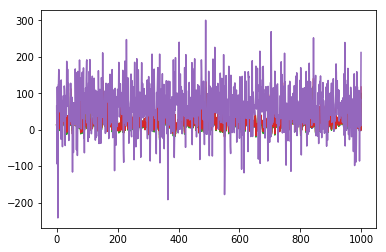

In [30]:
plt.plot(new_x)

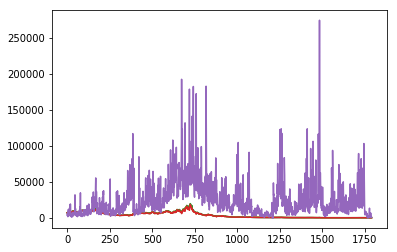

In [31]:
plt.plot(x_train)

### Comparing Original and Generated Data

In [29]:
org_x = load_data('datanp')
org_x1 = []
org_x2 = []

for xs in org_x:
    org_x1.append(xs[0])
    org_x2.append(xs[1])

print('Statistics for original dataset')
print('X1 Mean: {}\nX1 Standard Deviation: {}\n'.format(np.mean(org_x1), np.std(org_x1)))
print('X2 Mean: {}\nX2 Standard Deviation: {}\n'.format(np.mean(org_x2), np.std(org_x2)))

gen_x = load_data('av')
gen_x1 = []
gen_x2 = []

for xs in gen_x:
    gen_x1.append(xs[0])
    gen_x2.append(xs[1])
    
print('Statistics for generated dataset')
print('X1 Mean: {}\nX1 Standard Deviation: {}\n'.format(np.mean(gen_x1), np.std(gen_x1)))
print('X2 Mean: {}\nX2 Standard Deviation: {}\n'.format(np.mean(gen_x2), np.std(gen_x2)))

# Check if there are duplicate values of x1 and x2 between original and generated dataset

dup_count = 0
for idx_gen in range(0, len(gen_x)):
    for idx_org in range(0, len(org_x)):
        if gen_x1[idx_gen] == org_x1[idx_org] and gen_x2[idx_gen] == org_x2[idx_org]:
            dup_count += 1
            
print('Number of duplicated data: {}'.format(dup_count))

Statistics for original dataset
X1 Mean: 3943.0637353433845
X1 Standard Deviation: 3963.4771089261694

X2 Mean: 3939.515572305974
X2 Standard Deviation: 3963.894401372093

Statistics for generated dataset
X1 Mean: 19.966136932373047
X1 Standard Deviation: 18.86258888244629

X2 Mean: 17.88066291809082
X2 Standard Deviation: 12.044404029846191

Number of duplicated data: 0


## Numerical Data + Label

### Generating Numerical Data + Label

In [8]:
mu_x1 = 0
sd_x1 = 1

x1 = np.random.normal(mu_x1, sd_x1, 10000)

print(np.mean(x1))
print(np.std(x1))

mu_x2 = 5
sd_x2 = 2

x2 = np.random.normal(mu_x2, sd_x2, 10000)

print(np.mean(x2))
print(np.std(x2))

y_train = np.empty_like(x1)

epsilon = np.random.normal(0, 1, 10000)
for idx in range (len(y_train)):
    y_train[idx] = 2*x1[idx]*x1[idx] + x2[idx] + epsilon[idx]

x_train = np.stack((x1, x2))
x_train = np.transpose(x_train)

print(np.mean(y_train))
print(np.std(y_train))
print(y_train.shape)

# save_data(x_train, file_name='numerical-label-train-x')
# save_data(y_train, file_name='numerical-label-train-y')

0.002815729211789675
1.0085201902544954
5.011537331160059
2.003526473070175
7.045430071758438
3.664700804324905
(10000,)


In [9]:
mu_x1 = 0
sd_x1 = 1

x1 = np.random.normal(mu_x1, sd_x1, 5000)

print(np.mean(x1))
print(np.std(x1))

mu_x2 = 5
sd_x2 = 2

x2 = np.random.normal(mu_x2, sd_x2, 5000)

print(np.mean(x2))
print(np.std(x2))

y_test = np.empty_like(x1)

epsilon = np.random.normal(0, 1, 5000)
for idx in range (len(y_test)):
    y_test[idx] = 2*x1[idx]*x1[idx] + x2[idx] + epsilon[idx]

x_test = np.stack((x1, x2))
x_test = np.transpose(x_test)

print(np.mean(y_test))
print(np.std(y_test))
print(y_test.shape)

# save_data(x_test, file_name='numerical-label-test-x')
# save_data(y_test, file_name='numerical-label-test-y')

-0.026197153228951595
0.9852285568294048
5.02363987897211
1.997252339126335
6.9787391285606954
3.561402703425572
(5000,)


### Classifier for Numerical Data + Label

In [10]:
class ClassifierNumerical():
    
    def __init__(self):
        self.data_shape = (2,)
        self.classifier = self.build_classifier()
        
        self.classifier.compile(optimizer='adam',
                                loss='mean_squared_error',
                                metrics=['mean_squared_error'])
    
    def save_model(self, version=None):
        if version is None:
            self.classifier.save('gan/models/toy-numerical-classifier.h5')
        else:
            self.classifier.save('gan/models/toy-numerical-classifier-{}.h5'.format(version))
            
    
    def load_model(self, version=None):
        if version is None:
            self.classifier = load_model('gan/models/toy-numerical-classifier.h5')
        else:
            self.classifier = load_model('gan/models/toy-numerical-classifier-{}.h5'.format(version))

            
    def build_classifier(self):
        model = Sequential()
        model.add(Dense(32,
                        activation='relu',
                        input_shape=self.data_shape))
        model.add(Dense(16,
                        activation='tanh'))
        model.add(Dense(8,
                        activation='relu'))
        model.add(Dense(4,
                        activation='relu'))
        model.add(Dense(1))
        
        model.summary()
        
        return model
    
    def train(self, x_train, y_train, epoch_limit=10001, batch_size=128, version=''):
        
        history = self.classifier.fit(x_train, y_train,
                                     batch_size=batch_size,
                                     epochs=epoch_limit,
                                     verbose=1)

        self.save_model(version)
    
    def evaluate(self, x_test, y_test):
        score = self.classifier.evaluate(x_test, y_test,
                                         verbose=1)
        print('Test Loss = {}, Test MSE = {}'.format(score[0], score[1]))

### Training Classifier

In [11]:
x_train = load_data('numerical-label-train-x')
y_train = load_data('numerical-label-train-y')

classifier = ClassifierNumerical()
# classifier.train(x_train, y_train, epoch_limit=101, version='v1')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_14 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 5         
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


### GAN for Numerical Data + Label

In [12]:
class GANNumericalLabel():
    
    def __init__(self):
        self.data_shape = (3,)
        self.noise_shape = (10,)

        # Manually tune down learning rate to avoid oscillation
        optimizer = Adam(lr=0.005, beta_1=0.5)

        # -------------
        # Discriminator
        # -------------
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mean_squared_error',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        # ---------
        # Generator
        # ---------
        self.generator = self.build_generator()
        self.generator.compile(loss='mean_squared_error',
                               optimizer=optimizer)
        # --------
        # Combined
        # --------
        # The combined model is created by stacking generator and discriminator.
        # Noise ---Generator--> Generated Data ---Discriminator--> Validity
        
        z = Input(shape=self.noise_shape)
        data = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        
        validity = self.discriminator(data)

        self.combined = Model(z, validity)
        self.combined.compile(loss='mean_squared_error',
                              optimizer=optimizer)

        
    def save_model(self, version=None):
        if version is None:
            self.discriminator.save('gan/models/toy-numerical-label-discriminator.h5')
            self.generator.save('gan/models/toy-numerical-label-generator.h5')
            self.combined.save('gan/models/toy-numerical-label-combined.h5')
        else:
            self.discriminator.save('gan/models/toy-numerical-label-discriminator-{}.h5'.format(version))
            self.generator.save('gan/models/toy-numerical-label-generator-{}.h5'.format(version))
            self.combined.save('gan/models/toy-numerical-label-combined-{}.h5'.format(version))
        
        
    def load_model(self, version=None): 
        if version is None:
            self.discriminator = load_model('gan/models/toy-numerical-label-discriminator.h5')
            self.generator = load_model('gan/models/toy-numerical-label-generator.h5')
            self.combined = load_model('gan/models/toy-numerical-label-combined.h5')
        else:
            self.discriminator = load_model('gan/models/toy-numerical-label-discriminator-{}.h5'.format(version))
            self.generator = load_model('gan/models/toy-numerical-label-generator-{}.h5'.format(version))
            self.combined = load_model('gan/models/toy-numerical-label-combined-{}.h5'.format(version))
            
        
    def build_discriminator(self):
        model = Sequential()
        model.add(Dense(4, input_shape=self.data_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()

        # Discriminator takes an image as an input and outputs its validity
        data = Input(shape=self.data_shape)
        validity = model(data)

        return Model(data, validity)

        
    def build_generator(self):
        # BatchNormalization maintains the mean activation close to 0
        # and the activation standard deviation close to 1
        model = Sequential()
        model.add(Dense(8, input_shape=self.noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(4))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(3))
        
        model.summary()

        # Generator takes noise as an input and outputs an image
        noise = Input(shape=self.noise_shape)
        data = model(noise)

        return Model(noise, data)
    
    
    def train(self, train_data, epochs=50001, batch_size=128, save_model_interval=10000):

        half_batch = int(batch_size / 2)
        
        for epoch in range(epochs):
            # -------------------
            # Train Discriminator
            # -------------------
            # Select a random half batch of images
            idx = np.random.randint(0, train_data.shape[0], half_batch)
            data = train_data[idx]

            # Generate a half batch of new images
            noise = np.random.normal(0, 1, (half_batch, 10))
            gen_data = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(data, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_data, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------
            # Train Generator
            # ---------------
            noise = np.random.normal(0, 1, (batch_size, 10))

            # The generator wants to fool the discriminator, hence trained with valid label (1)
            # valid_y = np.array([1] * batch_size)
            valid_y = np.ones((batch_size, 1))

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)


            # Print progress
            print ("{:5d} [D loss: {}, acc_real: {:2f}, acc_fake: {:2f}] [G loss: {}]".format(epoch, d_loss[0], 100*d_loss_real[1], 100*d_loss_fake[1], g_loss))

            with open('gan/logs/toy-numerical-label-gan.log', 'a') as log_file:
                log_file.write('{},{}\n'.format(d_loss[0], g_loss))
            
            # Save models at save_interval
            if epoch != 0 and epoch % save_model_interval == 0:
                self.save_model(version=str(epoch))

In [13]:
x_train = load_data('numerical-label-train-x')
y_train = load_data('numerical-label-train-y')

expanded_y_train = np.expand_dims(y_train, axis=1)
merged_train_data = np.concatenate((x_train, expanded_y_train), axis=1)

gan = GANNumericalLabel()
# gan.train(merged_train_data)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 4)                 16        
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 40        
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 9         
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dens

### Generating New Numerical Data + Label with GAN

In [14]:
gan = GANNumericalLabel()
gan.load_model(version='v1')

noise = np.random.normal(0, 1, (1000, 10))
new_numerical_label_data = gan.generator.predict(noise)

# save_data(new_numerical_label_data, file_name = 'numerical-label-generated')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 4)                 16        
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 4)                 0         
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 40        
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 9         
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dens

/home/rionaldichandraseta/miniconda3/envs/gan-keras/lib/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


### Comparing Original and Generated Data

In [15]:
org_x = load_data('numerical-label-train-x')
org_y = load_data('numerical-label-train-y')
org_x1 = []
org_x2 = []

for xs in org_x:
    org_x1.append(xs[0])
    org_x2.append(xs[1])

print('Statistics for original dataset')
print('X1 Mean: {}\nX1 Standard Deviation: {}\n'.format(np.mean(org_x1), np.std(org_x1)))
print('X2 Mean: {}\nX2 Standard Deviation: {}\n'.format(np.mean(org_x2), np.std(org_x2)))
print('Y  Mean: {}\nY  Standard Deviation: {}\n'.format(np.mean(org_y), np.std(org_y)))

gen_data = load_data('numerical-label-generated')
gen_x1 = []
gen_x2 = []
gen_y = []

for data in gen_data:
    gen_x1.append(data[0])
    gen_x2.append(data[1])
    gen_y.append(data[2])
    
print('Statistics for generated dataset')
print('X1 Mean: {}\nX1 Standard Deviation: {}\n'.format(np.mean(gen_x1), np.std(gen_x1)))
print('X2 Mean: {}\nX2 Standard Deviation: {}\n'.format(np.mean(gen_x2), np.std(gen_x2)))
print('Y  Mean: {}\nY  Standard Deviation: {}\n'.format(np.mean(gen_y), np.std(gen_y)))

Statistics for original dataset
X1 Mean: -0.009102463775850814
X1 Standard Deviation: 0.9998558420656466

X2 Mean: 5.006042971999659
X2 Standard Deviation: 1.9744843293539256

Y  Mean: 7.012985457040965
Y  Standard Deviation: 3.5722964056680815

Statistics for generated dataset
X1 Mean: 0.0005220718448981643
X1 Standard Deviation: 0.9610234498977661

X2 Mean: 5.525527477264404
X2 Standard Deviation: 1.6596297025680542

Y  Mean: 7.321664333343506
Y  Standard Deviation: 3.0317885875701904



### Training New Classifier with GAN-generated Data

In [16]:
# Merge original and generated dataset

np_org_x1 = np.asarray(org_x1)
np_org_x2 = np.asarray(org_x2)
np_org_y = np.asarray(org_y)

np_gen_x1 = np.asarray(gen_x1)
np_gen_x2 = np.asarray(gen_x2)
np_gen_y = np.asarray(gen_y)

combined_x1 = np.concatenate((np_org_x1, np_gen_x1))
combined_x2 = np.concatenate((np_org_x2, np_gen_x2))
combined_y = np.concatenate((org_y, gen_y))

combined_x1 = np.expand_dims(combined_x1, axis=1)
combined_x2 = np.expand_dims(combined_x2, axis=1)
combined_y = np.expand_dims(combined_y, axis=1)
combined_training_data = np.concatenate((combined_x1, combined_x2, combined_y), axis=1)

# Train new classifier

new_classifier = ClassifierNumerical()
new_classifier.train(x_train, y_train, epoch_limit=101, version='with-gan')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_31 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_33 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 5         
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/101
10000/10000 [==============================] - 2s 177us/step - loss: 35.6012 - mean_squared_error: 35.6012
Epoch 2/101
10000/10000 [

### Comparing Classifier with and without GAN-generated Data

In [17]:
x_test = load_data('numerical-label-test-x')
y_test = load_data('numerical-label-test-y')

classifier = ClassifierNumerical()
classifier.load_model('v1')
classifier.evaluate(x_test, y_test)

new_classifier = ClassifierNumerical()
new_classifier.load_model('with-gan')
new_classifier.evaluate(x_test, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_36 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_37 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_38 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 5         
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
5000/5000 [==============================] - 1s 131us/step
Test Loss = 1.0211943440437317, Test MSE = 1.0211943440437317
_______________________

The evaluation score **improves slightly** by using the GAN-generated dataset as training data, the error dropped around 0.033.

## Categorical Data

### Generating One-Hot Encoded Categorical Data

In [18]:
def generate_categorical_data(mean, std, n_categories, n_data):
    
    distribution = np.random.normal(mean, std, n_data)
    
    # Around 99.7% datalies between 3 times standard deviation
    lower_bound = mean - (3 * std)
    upper_bound = mean + (3 * std)
    
    data_range = upper_bound - lower_bound
    category_range = data_range / n_categories
    
    categorical_data = []
    
    for data in distribution:
        category = int((data - lower_bound) / category_range)
        if category < 0:
            category = 0
        if category >= n_categories:
            category = n_categories - 1
            
        ohe_data = []
        
        for i in range (n_categories):
            if i == category:
                ohe_data.append(1)
            else:
                ohe_data.append(0)
            
        categorical_data.append(ohe_data)
    
    categorical_data = np.asarray(categorical_data)
    
    return categorical_data

In [19]:
feature1 = generate_categorical_data(0, 1, 5, 10000)
feature2 = generate_categorical_data(5, 2, 2, 10000)

combined_feature = np.concatenate((feature1, feature2), axis=1)
# save_data(combined_feature, file_name='categorical-original')


split_feature_1, split_feature_2 = np.split(combined_feature, [5], axis=1)

count = [0, 0, 0, 0, 0]
for c in split_feature_1:
    for idx, i in enumerate(c):
        if i == 1:
            count[idx] += 1
            
print(count)

count = [0, 0, 0, 0, 0]
for c in split_feature_2:
    for idx, i in enumerate(c):
        if i == 1:
            count[idx] += 1
            
print(count)

[339, 2422, 4460, 2398, 381]
[5018, 4982, 0, 0, 0]


### GAN for Categorical Data

In [20]:
class GANCategorical():
    
    def __init__(self):
        self.data_shape = (7,)
        self.noise_shape = (20,)

        # Manually tune down learning rate to avoid oscillation
        optimizer = Adam(lr=0.005, beta_1=0.5)

        # -------------
        # Discriminator
        # -------------
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mean_squared_error',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        
        # ---------
        # Generator
        # ---------
        self.generator = self.build_generator()
        self.generator.compile(loss='mean_squared_error',
                               optimizer=optimizer)
        

        # --------
        # Combined
        # --------
        # The combined model is created by stacking generator and discriminator.
        # Noise ---Generator--> Generated Data ---Discriminator--> Validity

        # From Generator
        z = Input(shape=self.noise_shape)
        data = self.generator(z)
        
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        validity = self.discriminator(data)

        self.combined = Model(inputs=z, outputs=validity)
        self.combined.compile(loss='mean_squared_error',
                              optimizer=optimizer)

        
    def save_model(self, version=None):
        if version is None:
            self.discriminator.save('gan/models/toy-categorical-discriminator.h5')
            self.generator.save('gan/models/toy-categorical-generator.h5')
            self.combined.save('gan/models/toy-categorical-combined.h5')
        else:
            self.discriminator.save('gan/models/toy-categorical-discriminator-{}.h5'.format(version))
            self.generator.save('gan/models/toy-categorical-generator-{}.h5'.format(version))
            self.combined.save('gan/models/toy-categorical-combined-{}.h5'.format(version))
        
        
    def load_model(self, version=None): 
        if version is None:
            self.discriminator = load_model('gan/models/toy-categorical-discriminator.h5')
            self.generator = load_model('gan/models/toy-categorical-generator.h5')
            self.combined = load_model('gan/models/toy-categorical-combined.h5')
        else:
            self.discriminator = load_model('gan/models/toy-categorical-discriminator-{}.h5'.format(version))
            self.generator = load_model('gan/models/toy-categorical-generator-{}.h5'.format(version))
            self.combined = load_model('gan/models/toy-categorical-combined-{}.h5'.format(version))
            
        
    def build_discriminator(self):
        model = Sequential()
        model.add(Dense(12, input_shape=self.data_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(6))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()

        # Discriminator takes an image as an input and outputs its validity
        data = Input(shape=self.data_shape)
        validity = model(data)

        return Model(data, validity)

        
    def build_generator(self):
        # BatchNormalization maintains the mean activation close to 0
        # and the activation standard deviation close to 1
        noise = Input(shape=self.noise_shape)
        
        hidden_1 = Dense(18)(noise)
        hidden_1 = LeakyReLU(alpha=0.2)(hidden_1)
        hidden_1 = BatchNormalization(momentum=0.8)(hidden_1)
        
        hidden_2 = Dense(14)(hidden_1)
        hidden_2 = LeakyReLU(alpha=0.2)(hidden_2)
        hidden_2 = BatchNormalization(momentum=0.8)(hidden_2)
        
        branch_1_hidden_1 = Dense(12)(hidden_2)
        branch_1_hidden_1 = LeakyReLU(alpha=0.2)(branch_1_hidden_1)
        branch_1_hidden_1 = BatchNormalization(momentum=0.8)(branch_1_hidden_1)
        
        branch_1_hidden_2 = Dense(7)(branch_1_hidden_1)
        branch_1_hidden_2 = LeakyReLU(alpha=0.2)(branch_1_hidden_2)
        branch_1_hidden_2 = BatchNormalization(momentum=0.8)(branch_1_hidden_2)
        
        branch_1_output = Dense(5, activation='softmax')(branch_1_hidden_2)
        
        branch_2_hidden_1 = Dense(8)(hidden_2)
        branch_2_hidden_1 = LeakyReLU(alpha=0.2)(branch_2_hidden_1)
        branch_2_hidden_1 = BatchNormalization(momentum=0.8)(branch_2_hidden_1)
        
        branch_2_hidden_2 = Dense(4)(branch_2_hidden_1)
        branch_2_hidden_2 = LeakyReLU(alpha=0.2)(branch_2_hidden_2)
        branch_2_hidden_2 = BatchNormalization(momentum=0.8)(branch_2_hidden_2)
        
        branch_2_output = Dense(2, activation='softmax')(branch_2_hidden_2)
        
        merged_output = concatenate([branch_1_output, branch_2_output])
        
        return Model(inputs=noise, outputs=merged_output)
    
    
    def train(self, train_data, epochs=50001, batch_size=128, save_model_interval=10000):

        half_batch = int(batch_size / 2)
        
        for epoch in range(epochs):
            # -------------------
            # Train Discriminator
            # -------------------
            # Select a random half batch of images
            idx = np.random.randint(0, train_data.shape[0], half_batch)
            data = train_data[idx]

            # Generate a half batch of new images
            noise = np.random.normal(0, 1, (half_batch, 20))
            gen_data = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(data, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_data, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------
            # Train Generator
            # ---------------
            noise = np.random.normal(0, 1, (batch_size, 20))

            # The generator wants to fool the discriminator, hence trained with valid label (1)
            # valid_y = np.array([1] * batch_size)
            valid_y = np.ones((batch_size, 1))

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)


            # Print progress
            print ("{:5d} [D loss: {}, acc_real: {:2f}, acc_fake: {:2f}] [G loss: {}]".format(epoch, d_loss[0], 100*d_loss_real[1], 100*d_loss_fake[1], g_loss))

            with open('gan/logs/toy-categorical-gan.log', 'a') as log_file:
                log_file.write('{},{}\n'.format(d_loss[0], g_loss))
            
            # Save models at save_interval
            if epoch != 0 and epoch % save_model_interval == 0:
                self.save_model(version=str(epoch))

In [21]:
categorical_data = load_data('categorical-original')

gan = GANCategorical()
# gan.train(categorical_data)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 12)                96        
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 12)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 6)                 78        
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 6)                 0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 7         
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


### Generating New Categorical Data with GAN

In [22]:
noise = np.random.normal(0, 1, (1000, 20))

gan = GANCategorical()
gan.load_model('v1')

generated_feature = gan.generator.predict(noise)

split_generated_feature_1, split_generated_feature_2 = np.split(generated_feature, [5], axis=1)

count = [0, 0, 0, 0, 0]
for c in split_generated_feature_1:
    for idx, i in enumerate(c):
        if i == 1:
            count[idx] += 1
            
print(count)

count = [0, 0, 0, 0, 0]
for c in split_generated_feature_2:
    for idx, i in enumerate(c):
        if i == 1:
            count[idx] += 1
            
print(count)

generated_feature = generated_feature.astype(int)
# save_data(generated_feature, file_name='categorical-generated')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 12)                96        
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 12)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 6)                 78        
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 6)                 0         
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 7         
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


/home/rionaldichandraseta/miniconda3/envs/gan-keras/lib/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


[1, 257, 453, 236, 14]
[548, 428, 0, 0, 0]


## Categorical Data + Label

### Generating Categorical Data + Label

In [23]:
# Generate label for the categorical data

categorical_data = load_data('categorical-original')

feature_1, feature_2 = np.split(categorical_data, [5], axis=1)

print(feature_1.shape)
print(feature_2.shape)

epsilon = np.random.normal(0, 1, 10000)
label = []
for idx in range(feature_1.shape[0]):
    value = 0
    for idx_f1 in range(feature_1.shape[1]):
        if feature_1[idx][idx_f1] == 1:
            value += idx_f1 * 3
    
    for idx_f2 in range(feature_2.shape[1]):
        if feature_2[idx][idx_f2] == 1:
            value -= idx_f2 * 5
            
    value += epsilon[idx]
    
    if value < 1:
        label.append([1,0,0])
    elif 1 <= value <= 7:
        label.append([0,1,0])
    else:
        label.append([0,0,1])
        
label = np.asarray(label)

count = [0,0,0]
for l in label:
    for idx, i in enumerate(l):
        if i == 1:
            count[idx] += 1
            
print(count)

# save_data(categorical_data, file_name='categorical-label-train-x')
# save_data(label, file_name='categorical-label-train-y')

(10000, 5)
(10000, 2)
[2747, 5509, 1744]


Decided to skip on the GAN and classifier for Categorical + Label and head straight to Mixed dataset

## Mixed (Categorical + Numerical + Label)

### Generating Mixed Data

In [24]:
# Generate training data for mixed dataset
n_data_train = 10000

train_categorical_1 = generate_categorical_data(0, 1, 5, n_data_train)
train_categorical_2 = generate_categorical_data(5, 2, 2, n_data_train)

train_numerical_1 = np.random.normal(0, 1, n_data_train)
train_numerical_2 = np.random.normal(5, 2, n_data_train)

epsilon = np.random.normal(0, 1, n_data_train)
train_label = []
for idx in range(n_data_train):
    value = 0
    for idx_c1 in range(train_categorical_1.shape[1]):
        if train_categorical_1[idx][idx_c1] == 1:
            value += idx_c1 * 3
    
    for idx_c2 in range(train_categorical_2.shape[1]):
        if train_categorical_2[idx][idx_c2] == 1:
            value -= idx_f2 * 5
            
    value += train_numerical_1[idx] * 4
    value += train_numerical_2[idx] / 2
            
    value += epsilon[idx]
    
    if value < 1:
        train_label.append([1,0,0])
    elif 1 <= value <= 7:
        train_label.append([0,1,0])
    else:
        train_label.append([0,0,1])
        
train_label = np.asarray(train_label)

count = [0,0,0]
for label in train_label:
    for idx, i in enumerate(label):
        if i == 1:
            count[idx] += 1
            
print(count)

train_numerical_1 = np.expand_dims(train_numerical_1, axis=1)
train_numerical_2 = np.expand_dims(train_numerical_2, axis=1)

train_data = np.concatenate((train_categorical_1, train_categorical_2, train_numerical_1, train_numerical_2), axis=1)

save_data(train_data, file_name='mix-label-train-x')
save_data(train_label, file_name='mix-label-train-y')

# Generate test data for mixed dataset
n_data_test = 5000

test_categorical_1 = generate_categorical_data(0, 1, 5, n_data_test)
test_categorical_2 = generate_categorical_data(5, 2, 2, n_data_test)

test_numerical_1 = np.random.normal(0, 1, n_data_test)
test_numerical_2 = np.random.normal(5, 2, n_data_test)

epsilon = np.random.normal(0, 1, n_data_test)
test_label = []
for idx in range(n_data_test):
    value = 0
    for idx_c1 in range(test_categorical_1.shape[1]):
        if test_categorical_1[idx][idx_c1] == 1:
            value += idx_c1 * 3
    
    for idx_c2 in range(test_categorical_2.shape[1]):
        if test_categorical_2[idx][idx_c2] == 1:
            value -= idx_f2 * 5
            
    value += test_numerical_1[idx] * 4
    value += test_numerical_2[idx] / 2
            
    value += epsilon[idx]
    
    if value < 1:
        test_label.append([1,0,0])
    elif 1 <= value <= 7:
        test_label.append([0,1,0])
    else:
        test_label.append([0,0,1])
        
test_label = np.asarray(test_label)

count = [0,0,0]
for label in test_label:
    for idx, i in enumerate(label):
        if i == 1:
            count[idx] += 1
            
print(count)

test_numerical_1 = np.expand_dims(test_numerical_1, axis=1)
test_numerical_2 = np.expand_dims(test_numerical_2, axis=1)

test_data = np.concatenate((test_categorical_1, test_categorical_2, test_numerical_1, test_numerical_2), axis=1)
save_data(test_data, file_name='mix-label-test-x')
save_data(test_label, file_name='mix-label-test-y')

[3110, 4541, 2349]
Data successfully saved to gan/gen-data/mix-label-train-x
Data successfully saved to gan/gen-data/mix-label-train-y
[1559, 2235, 1206]
Data successfully saved to gan/gen-data/mix-label-test-x
Data successfully saved to gan/gen-data/mix-label-test-y


### Classifier for Mixed Data

In [25]:
class ClassifierMix():
    
    def __init__(self):
        self.input_shape = (9,)
        self.classifier = self.build_classifier()
        
        self.classifier.compile(optimizer='adam',
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])
    
    def save_model(self, version=None):
        if version is None:
            self.classifier.save('gan/models/toy-mix-classifier.h5')
        else:
            self.classifier.save('gan/models/toy-mix-classifier-{}.h5'.format(version))
            
    
    def load_model(self, version=None):
        if version is None:
            self.classifier = load_model('gan/models/toy-mix-classifier.h5')
        else:
            self.classifier = load_model('gan/models/toy-mix-classifier-{}.h5'.format(version))

            
    def build_classifier(self):
        model = Sequential()
        model.add(Dense(128, 
                        activation='relu',
                        input_shape=self.input_shape))
        model.add(Dropout(0.2))
        model.add(Dense(64,
                        activation='tanh'))
        model.add(Dropout(0.2))
        model.add(Dense(32,
                        activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(16,
                        activation='tanh'))
        model.add(Dropout(0.2))
        model.add(Dense(3, activation='softmax'))
        
        model.summary()
        
        return model
    
    def train(self, x_train, y_train, epoch_limit=10001, batch_size=128, version=''):
        
        history = self.classifier.fit(x_train, y_train,
                                     batch_size=batch_size,
                                     epochs=epoch_limit,
                                     verbose=1)

        self.save_model(version)
    
    def evaluate(self, x_test, y_test):
        score = self.classifier.evaluate(x_test, y_test,
                                         verbose=1)
        print('Test Loss = {}, Test Accuracy = {}'.format(score[0], score[1]))

### Training Classifier

In [35]:
x_train = load_data('mix-label-train-x')
y_train = load_data('mix-label-train-y')

classifier_mix = ClassifierMix()
# classifier_mix.train(x_train, y_train, epoch_limit=1000, version='v1')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_138 (Dense)            (None, 128)               1280      
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_139 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_140 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_19 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_141 (Dense)            (None, 16)                528       
__________

### GAN for Mixed Data + Label

In [27]:
class GANMixWithLabel():
    
    def __init__(self):
        self.data_shape = (12,)
            # Categorical 5
            # Categorical 2
            # Numerical 1
            # Numerical 1
            # Label 3
        self.noise_shape = (20,)

        # Manually tune down learning rate to avoid oscillation
        optimizer = Adam(lr=0.005, beta_1=0.5)

        # -------------
        # Discriminator
        # -------------
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mean_squared_error',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        
        # ---------
        # Generator
        # ---------
        self.generator = self.build_generator()
        self.generator.compile(loss='mean_squared_error',
                               optimizer=optimizer)
        

        # --------
        # Combined
        # --------
        # The combined model is created by stacking generator and discriminator.
        # Noise ---Generator--> Generated Data ---Discriminator--> Validity

        # From Generator
        z = Input(shape=self.noise_shape)
        data = self.generator(z)
        
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        validity = self.discriminator(data)

        self.combined = Model(inputs=z, outputs=validity)
        self.combined.compile(loss='mean_squared_error',
                              optimizer=optimizer)

        
    def save_model(self, version=None):
        if version is None:
            self.discriminator.save('gan/models/toy-mix-label-discriminator.h5')
            self.generator.save('gan/models/toy-mix-label-generator.h5')
            self.combined.save('gan/models/toy-mix-label-combined.h5')
        else:
            self.discriminator.save('gan/models/toy-mix-label-discriminator-{}.h5'.format(version))
            self.generator.save('gan/models/toy-mix-label-generator-{}.h5'.format(version))
            self.combined.save('gan/models/toy-mix-label-combined-{}.h5'.format(version))
        
        
    def load_model(self, version=None): 
        if version is None:
            self.discriminator = load_model('gan/models/toy-mix-label-discriminator.h5')
            self.generator = load_model('gan/models/toy-mix-label-generator.h5')
            self.combined = load_model('gan/models/toy-mix-label-combined.h5')
        else:
            self.discriminator = load_model('gan/models/toy-mix-label-discriminator-{}.h5'.format(version))
            self.generator = load_model('gan/models/toy-mix-label-generator-{}.h5'.format(version))
            self.combined = load_model('gan/models/toy-mix-label-combined-{}.h5'.format(version))
            
        
    def build_discriminator(self):
        model = Sequential()
        model.add(Dense(12, input_shape=self.data_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(6))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()

        # Discriminator takes an image as an input and outputs its validity
        data = Input(shape=self.data_shape)
        validity = model(data)

        return Model(data, validity)
    
        
    def build_generator(self):
        # BatchNormalization maintains the mean activation close to 0
        # and the activation standard deviation close to 1
        noise = Input(shape=self.noise_shape)
        
        hidden_1 = Dense(18)(noise)
        hidden_1 = LeakyReLU(alpha=0.2)(hidden_1)
        hidden_1 = BatchNormalization(momentum=0.8)(hidden_1)
        
        hidden_2 = Dense(16)(hidden_1)
        hidden_2 = LeakyReLU(alpha=0.2)(hidden_2)
        hidden_2 = BatchNormalization(momentum=0.8)(hidden_2)
            
        # Branch 1 - Categorical (5)
        branch_1_hidden_1 = Dense(12)(hidden_2)
        branch_1_hidden_1 = LeakyReLU(alpha=0.2)(branch_1_hidden_1)
        branch_1_hidden_1 = BatchNormalization(momentum=0.8)(branch_1_hidden_1)
        
        branch_1_hidden_2 = Dense(7)(branch_1_hidden_1)
        branch_1_hidden_2 = LeakyReLU(alpha=0.2)(branch_1_hidden_2)
        branch_1_hidden_2 = BatchNormalization(momentum=0.8)(branch_1_hidden_2)
        
        branch_1_output = Dense(5, activation='softmax')(branch_1_hidden_2)
        
        # Branch 2 - Categorical (2)
        branch_2_hidden_1 = Dense(8)(hidden_2)
        branch_2_hidden_1 = LeakyReLU(alpha=0.2)(branch_2_hidden_1)
        branch_2_hidden_1 = BatchNormalization(momentum=0.8)(branch_2_hidden_1)

        branch_2_hidden_2 = Dense(4)(branch_2_hidden_1)
        branch_2_hidden_2 = LeakyReLU(alpha=0.2)(branch_2_hidden_2)
        branch_2_hidden_2 = BatchNormalization(momentum=0.8)(branch_2_hidden_2)
        
        branch_2_output = Dense(2, activation='softmax')(branch_2_hidden_2)
        
        # Branch 3 - Numerical
        branch_3_hidden_1 = Dense(4)(hidden_2)
        branch_3_hidden_1 = LeakyReLU(alpha=0.2)(branch_3_hidden_1)
        branch_3_hidden_1 = BatchNormalization(momentum=0.8)(branch_3_hidden_1)
        
        branch_3_output = Dense(1)(branch_3_hidden_1)
        
        # Branch 4 - Numerical
        branch_4_hidden_1 = Dense(4)(hidden_2)
        branch_4_hidden_1 = LeakyReLU(alpha=0.2)(branch_4_hidden_1)
        branch_4_hidden_1 = BatchNormalization(momentum=0.8)(branch_4_hidden_1)
        
        branch_4_output = Dense(1)(branch_4_hidden_1)
        
        # Branch 5 - Label (3)
        branch_5_hidden_1 = Dense(10)(hidden_2)
        branch_5_hidden_1 = LeakyReLU(alpha=0.2)(branch_5_hidden_1)
        branch_5_hidden_1 = BatchNormalization(momentum=0.8)(branch_5_hidden_1)
        
        branch_5_hidden_2 = Dense(6)(branch_5_hidden_1)
        branch_5_hidden_2 = LeakyReLU(alpha=0.2)(branch_5_hidden_2)
        branch_5_hidden_2 = BatchNormalization(momentum=0.8)(branch_5_hidden_2)
        
        branch_5_output = Dense(3, activation='softmax')(branch_5_hidden_2)
        
        merged_output = concatenate([branch_1_output, branch_2_output, branch_3_output, branch_4_output, branch_5_output])
        
        return Model(inputs=noise, outputs=merged_output)
    
    
    def train(self, train_data, epochs=50001, batch_size=128, save_model_interval=10000):

        half_batch = int(batch_size / 2)
        
        for epoch in range(epochs):
            # -------------------
            # Train Discriminator
            # -------------------
            # Select a random half batch of images
            idx = np.random.randint(0, train_data.shape[0], half_batch)
            data = train_data[idx]

            # Generate a half batch of new images
            noise = np.random.normal(0, 1, (half_batch, 20))
            gen_data = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(data, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_data, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------
            # Train Generator
            # ---------------
            noise = np.random.normal(0, 1, (batch_size, 20))

            # The generator wants to fool the discriminator, hence trained with valid label (1)
            # valid_y = np.array([1] * batch_size)
            valid_y = np.ones((batch_size, 1))

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)


            # Print progress
            print ("{:5d} [D loss: {}, acc_real: {:2f}, acc_fake: {:2f}] [G loss: {}]".format(epoch, d_loss[0], 100*d_loss_real[1], 100*d_loss_fake[1], g_loss))

            with open('gan/logs/toy-mix-label-gan.log', 'a') as log_file:
                log_file.write('{},{}\n'.format(d_loss[0], g_loss))
            
            # Save models at save_interval
            if epoch != 0 and epoch % save_model_interval == 0:
                self.save_model(version=str(epoch))

In [28]:
x_train = load_data('mix-label-train-x')
y_train = load_data('mix-label-train-y')

train_data = np.concatenate((x_train, y_train), axis=1)

gan = GANMixWithLabel()
# gan.train(train_data, epochs=100001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 12)                156       
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 12)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 6)                 78        
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 6)                 0         
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 7         
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


### Generating New Mixed Data with GAN

In [36]:
gan_mix = GANMixWithLabel()
gan_mix.load_model('v1')

noise = np.random.normal(0, 1, (1000, 20))

generated_data = gan_mix.generator.predict(noise)
# save_data(generated_data, file_name='mix-label-generated')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_143 (Dense)            (None, 12)                156       
_________________________________________________________________
leaky_re_lu_67 (LeakyReLU)   (None, 12)                0         
_________________________________________________________________
dense_144 (Dense)            (None, 6)                 78        
_________________________________________________________________
leaky_re_lu_68 (LeakyReLU)   (None, 6)                 0         
_________________________________________________________________
dense_145 (Dense)            (None, 1)                 7         
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


/home/rionaldichandraseta/miniconda3/envs/gan-keras/lib/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


### Normalize Generated Data

In [37]:
generated_data = load_data('mix-label-generated')

categorical_1, categorical_2, numerical_1, numerical_2, label = np.split(generated_data, [5, 7, 8, 9], axis=1)

categorical_1 = np.round(categorical_1)
categorical_2 = np.round(categorical_2)
label = np.round(label)

categorical_1 = categorical_1.astype(int)
categorical_2 = categorical_2.astype(int)
label = label.astype(int)

generated_data_normalized = np.concatenate((categorical_1, categorical_2, numerical_1, numerical_2, label), axis=1)

# save_data(generated_data_normalized, file_name='mix-label-generated-normalized')

### Training New Classifier with GAN-Generated Data

In [106]:
org_x_train = load_data('mix-label-train-x')
org_y_train = load_data('mix-label-train-y')

generated_data = load_data('mix-label-generated-normalized')

gen_x_train, gen_y_train = np.split(generated_data, [9], axis=1)

x_train = np.concatenate((org_x_train, gen_x_train), axis=0)
y_train = np.concatenate((org_y_train, gen_y_train), axis=0)

classifier_mix = ClassifierMix()
# classifier_mix.train(x_train, y_train, epoch_limit=1000, version='with-gan-v1')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_301 (Dense)            (None, 128)               1280      
_________________________________________________________________
dropout_49 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_302 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_50 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_303 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_51 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_304 (Dense)            (None, 16)                528       
__________

### Comparing Classifier with and without GAN-generated Data

In [107]:
x_test = load_data('mix-label-test-x')
y_test = load_data('mix-label-test-y')

classifier = ClassifierMix()
classifier.load_model('v1')
classifier.evaluate(x_test, y_test)

new_classifier = ClassifierMix()
new_classifier.load_model('with-gan-v1')
new_classifier.evaluate(x_test, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_306 (Dense)            (None, 128)               1280      
_________________________________________________________________
dropout_53 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_307 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_54 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_308 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_55 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_309 (Dense)            (None, 16)                528       
__________

Accuracy of the model increased from 88.32% to 88.36%, an increase of 2 more correct samples

### GAN for Mixed Data without Generating Label

In [33]:
class GANMix():
    
    def __init__(self):
        self.data_shape = (9,)
            # Categorical 5
            # Categorical 2
            # Numerical 1
            # Numerical 1
        self.noise_shape = (20,)

        # Manually tune down learning rate to avoid oscillation
        optimizer = Adam(lr=0.005, beta_1=0.5)

        # -------------
        # Discriminator
        # -------------
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mean_squared_error',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        
        # ---------
        # Generator
        # ---------
        self.generator = self.build_generator()
        self.generator.compile(loss='mean_squared_error',
                               optimizer=optimizer)
        

        # --------
        # Combined
        # --------
        # The combined model is created by stacking generator and discriminator.
        # Noise ---Generator--> Generated Data ---Discriminator--> Validity

        # From Generator
        z = Input(shape=self.noise_shape)
        data = self.generator(z)
        
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        validity = self.discriminator(data)

        self.combined = Model(inputs=z, outputs=validity)
        self.combined.compile(loss='mean_squared_error',
                              optimizer=optimizer)

        
    def save_model(self, version=None):
        if version is None:
            self.discriminator.save('gan/models/toy-mix-discriminator.h5')
            self.generator.save('gan/models/toy-mix-generator.h5')
            self.combined.save('gan/models/toy-mix-combined.h5')
        else:
            self.discriminator.save('gan/models/toy-mix-discriminator-{}.h5'.format(version))
            self.generator.save('gan/models/toy-mix-generator-{}.h5'.format(version))
            self.combined.save('gan/models/toy-mix-combined-{}.h5'.format(version))
        
        
    def load_model(self, version=None): 
        if version is None:
            self.discriminator = load_model('gan/models/toy-mix-discriminator.h5')
            self.generator = load_model('gan/models/toy-mix-generator.h5')
            self.combined = load_model('gan/models/toy-mix-combined.h5')
        else:
            self.discriminator = load_model('gan/models/toy-mix-discriminator-{}.h5'.format(version))
            self.generator = load_model('gan/models/toy-mix-generator-{}.h5'.format(version))
            self.combined = load_model('gan/models/toy-mix-combined-{}.h5'.format(version))
            
        
    def build_discriminator(self):
        model = Sequential()
        model.add(Dense(12, input_shape=self.data_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(6))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()

        # Discriminator takes an image as an input and outputs its validity
        data = Input(shape=self.data_shape)
        validity = model(data)

        return Model(data, validity)
    
        
    def build_generator(self):
        # BatchNormalization maintains the mean activation close to 0
        # and the activation standard deviation close to 1
        noise = Input(shape=self.noise_shape)
        
        hidden_1 = Dense(18)(noise)
        hidden_1 = LeakyReLU(alpha=0.2)(hidden_1)
        hidden_1 = BatchNormalization(momentum=0.8)(hidden_1)
        
        hidden_2 = Dense(16)(hidden_1)
        hidden_2 = LeakyReLU(alpha=0.2)(hidden_2)
        hidden_2 = BatchNormalization(momentum=0.8)(hidden_2)
            
        # Branch 1 - Categorical (5)
        branch_1_hidden_1 = Dense(12)(hidden_2)
        branch_1_hidden_1 = LeakyReLU(alpha=0.2)(branch_1_hidden_1)
        branch_1_hidden_1 = BatchNormalization(momentum=0.8)(branch_1_hidden_1)
        
        branch_1_hidden_2 = Dense(7)(branch_1_hidden_1)
        branch_1_hidden_2 = LeakyReLU(alpha=0.2)(branch_1_hidden_2)
        branch_1_hidden_2 = BatchNormalization(momentum=0.8)(branch_1_hidden_2)
        
        branch_1_output = Dense(5, activation='softmax')(branch_1_hidden_2)
        
        # Branch 2 - Categorical (2)
        branch_2_hidden_1 = Dense(8)(hidden_2)
        branch_2_hidden_1 = LeakyReLU(alpha=0.2)(branch_2_hidden_1)
        branch_2_hidden_1 = BatchNormalization(momentum=0.8)(branch_2_hidden_1)

        branch_2_hidden_2 = Dense(4)(branch_2_hidden_1)
        branch_2_hidden_2 = LeakyReLU(alpha=0.2)(branch_2_hidden_2)
        branch_2_hidden_2 = BatchNormalization(momentum=0.8)(branch_2_hidden_2)
        
        branch_2_output = Dense(2, activation='softmax')(branch_2_hidden_2)
        
        # Branch 3 - Numerical
        branch_3_hidden_1 = Dense(4)(hidden_2)
        branch_3_hidden_1 = LeakyReLU(alpha=0.2)(branch_3_hidden_1)
        branch_3_hidden_1 = BatchNormalization(momentum=0.8)(branch_3_hidden_1)
        
        branch_3_output = Dense(1)(branch_3_hidden_1)
        
        # Branch 4 - Numerical
        branch_4_hidden_1 = Dense(4)(hidden_2)
        branch_4_hidden_1 = LeakyReLU(alpha=0.2)(branch_4_hidden_1)
        branch_4_hidden_1 = BatchNormalization(momentum=0.8)(branch_4_hidden_1)
        
        branch_4_output = Dense(1)(branch_4_hidden_1)
        
        merged_output = concatenate([branch_1_output, branch_2_output, branch_3_output, branch_4_output])
        
        return Model(inputs=noise, outputs=merged_output)
    
    
    def train(self, train_data, epochs=50001, batch_size=128, save_model_interval=10000):

        half_batch = int(batch_size / 2)
        
        for epoch in range(epochs):
            # -------------------
            # Train Discriminator
            # -------------------
            # Select a random half batch of images
            idx = np.random.randint(0, train_data.shape[0], half_batch)
            data = train_data[idx]

            # Generate a half batch of new images
            noise = np.random.normal(0, 1, (half_batch, 20))
            gen_data = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(data, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_data, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------
            # Train Generator
            # ---------------
            noise = np.random.normal(0, 1, (batch_size, 20))

            # The generator wants to fool the discriminator, hence trained with valid label (1)
            # valid_y = np.array([1] * batch_size)
            valid_y = np.ones((batch_size, 1))

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)


            # Print progress
            print ("{:5d} [D loss: {}, acc_real: {:2f}, acc_fake: {:2f}] [G loss: {}]".format(epoch, d_loss[0], 100*d_loss_real[1], 100*d_loss_fake[1], g_loss))

            with open('gan/logs/toy-mix-gan.log', 'a') as log_file:
                log_file.write('{},{}\n'.format(d_loss[0], g_loss))
            
            # Save models at save_interval
            if epoch != 0 and epoch % save_model_interval == 0:
                self.save_model(version=str(epoch))

In [40]:
x_train = load_data('mix-label-train-x')

gan = GANMix()
# gan.train(x_train, epochs=100001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_191 (Dense)            (None, 12)                120       
_________________________________________________________________
leaky_re_lu_99 (LeakyReLU)   (None, 12)                0         
_________________________________________________________________
dense_192 (Dense)            (None, 6)                 78        
_________________________________________________________________
leaky_re_lu_100 (LeakyReLU)  (None, 6)                 0         
_________________________________________________________________
dense_193 (Dense)            (None, 1)                 7         
Total params: 205
Trainable params: 205
Non-trainable params: 0
_________________________________________________________________


### Generating New Mixed Data

In [68]:
gan = GANMix()
gan.load_model('v1')

noise = np.random.normal(0, 1, (3000, 20))

generated_data = gan.generator.predict(noise)
# save_data(generated_data, file_name='mix-generated')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_261 (Dense)            (None, 12)                120       
_________________________________________________________________
leaky_re_lu_139 (LeakyReLU)  (None, 12)                0         
_________________________________________________________________
dense_262 (Dense)            (None, 6)                 78        
_________________________________________________________________
leaky_re_lu_140 (LeakyReLU)  (None, 6)                 0         
_________________________________________________________________
dense_263 (Dense)            (None, 1)                 7         
Total params: 205
Trainable params: 205
Non-trainable params: 0
_________________________________________________________________


/home/rionaldichandraseta/miniconda3/envs/gan-keras/lib/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Data successfully saved to gan/gen-data/mix-generated


### Normalize Generated Data

In [69]:
generated_data = load_data('mix-generated')

categorical_1, categorical_2, numerical_1, numerical_2 = np.split(generated_data, [5, 7, 8], axis=1)

categorical_1 = np.round(categorical_1)
categorical_2 = np.round(categorical_2)

categorical_1 = categorical_1.astype(int)
categorical_2 = categorical_2.astype(int)

generated_data_normalized = np.concatenate((categorical_1, categorical_2, numerical_1, numerical_2), axis=1)
# save_data(generated_data_normalized, file_name='mix-generated-normalized')

Data successfully saved to gan/gen-data/mix-generated-normalized


### Data Labelling with Classifier

In [73]:
x_train = load_data('mix-generated-normalized')

classifier = ClassifierMix()
classifier.load_model('v1')

predictions = classifier.classifier.predict(x_train)

# save_data(predictions, 'mix-generated-prediction')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_281 (Dense)            (None, 128)               1280      
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_282 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_34 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_283 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_35 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_284 (Dense)            (None, 16)                528       
__________

### Filter Data with Threshold

In [103]:
threshold = 0.999

generated_data = load_data('mix-generated-normalized')
predictions = load_data('mix-generated-prediction')
predictions_dummy = np.where(predictions > threshold, 1, 0)

n_class = 3

below_threshold_indices = []
below_threshold_count = 0
for i in range(len(predictions_dummy)):
    all_zero = True
    for j in range(n_class):
        if all_zero:
            all_zero = predictions_clone[i][j] == 0
        else:
            break
    if all_zero:
        below_threshold_indices.append(i)
        below_threshold_count += 1

print('Detected {} generated data that falls below the threshold of {}'.format(below_threshold_count, threshold))

above_threshold_indices = []
above_threshold_count = np.zeros(n_class)
for idx, prediction in enumerate(predictions):
    if idx not in below_threshold_indices:
        above_threshold_indices.append(idx)
        above_threshold_count[np.argmax(prediction)] += 1
        
print('Label distribution for data above threshold: {}'.format(above_threshold_count))

data_limit = [333, 334, 333]

filtered_generated_data = np.empty((1000,9))
normalized_label = np.empty((1000,3))

count = np.zeros(n_class)
it = 0
for idx in above_threshold_indices:
    data_label = np.argmax(predictions[idx])
    if count[data_label] >= data_limit[data_label]:
        pass
    else:
        filtered_generated_data[it] = generated_data[idx]
        normalized_label[it] = predictions[idx]
        count[data_label] += 1
        it += 1

normalized_label = np.round(normalized_label)


# Check labelled data distribution

count = [0,0,0]
for y in normalized_label:
    for j in range(3):
        if y[j] == 1:
            count[j] += 1

print('Filtered data label distribution: {}'.format(count))

# save_data(filtered_generated_data, 'mix-generated-x-above-threshold')
# save_data(normalized_label, 'mix-generated-y-above-threshold')

Detected 1620 generated data that falls below the threshold of 0.999
Label distribution for data above threshold: [499. 428. 453.]
Filtered data label distribution: [333, 334, 333]
Data successfully saved to gan/gen-data/mix-generated-x-above-threshold
Data successfully saved to gan/gen-data/mix-generated-y-above-threshold


### Training New Classifier with GAN Generated Data

In [108]:
org_x_train = load_data('mix-label-train-x')
org_y_train = load_data('mix-label-train-y')

gen_x_train = load_data('mix-generated-x-above-threshold')
gen_y_train = load_data('mix-generated-y-above-threshold')

x_train = np.concatenate((org_x_train, gen_x_train), axis=0)
y_train = np.concatenate((org_y_train, gen_y_train), axis=0)

classifier_mix = ClassifierMix()
# classifier_mix.train(x_train, y_train, epoch_limit=1000, version='with-gan-v2')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_316 (Dense)            (None, 128)               1280      
_________________________________________________________________
dropout_61 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_317 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_62 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_318 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_63 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_319 (Dense)            (None, 16)                528       
__________

### Comparing Classifier with and without GAN-generated Data

In [105]:
x_test = load_data('mix-label-test-x')
y_test = load_data('mix-label-test-y')

classifier = ClassifierMix()
classifier.load_model('v1')
classifier.evaluate(x_test, y_test)

new_classifier = ClassifierMix()
new_classifier.load_model('with-gan-v2')
new_classifier.evaluate(x_test, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_291 (Dense)            (None, 128)               1280      
_________________________________________________________________
dropout_41 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_292 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_42 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_293 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_43 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_294 (Dense)            (None, 16)                528       
__________

Accuracy of the model increased from 88.32% to 88.66%, an increase of 12 more correct samples